# Analysis

### Setup

In [1]:
# Imports
import json
import os
import sys
import pandas as pd
import numpy as np
import mdtraj as md
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sys.path.append('src')
import analyse_utils

## Initial test runs

In [2]:
# Loading metadata
initial = analyse_utils.load_metadata('exp/initial/initial.json')

initial

template                                           sequence  \
H1-0_WT        H1-0  TKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKA...   
H1-0_RAND      H1-0  PGTKKPKSTKTKKALAKAKKAKVKGSKAEKATSAAKKSVKPKKSKA...   
H1-0_CLUST     H1-0  KKKKKKKKKKRKKKKKKKKKKKKKKKKKKKKKRKKKKKKKKKKKKA...   
H2B_WT          H2B                MPDPAKSAPAPKKGSKKAVTKVQKKDGKKRKRSRK   
H2B_RAND        H2B                EKKKKSDMKPKRKPVASQAAKPKSRKKKTPGRGAA   
H2B_CLUST       H2B                RKRKKKKKKKRKKKKASAVTAAQGPPGSAPPMSED   

           location region                       variant uniprot_id species  \
H1-0_WT      83:194    CTD                     Wild type        NaN     NaN   
H1-0_RAND    83:194    CTD             Randomly shuffled        NaN     NaN   
H1-0_CLUST   83:194    CTD  Terminally clustered charges        NaN     NaN   
H2B_WT         0:36    NTD                     Wild type        NaN     NaN   
H2B_RAND       0:36    NTD             Randomly shuffled        NaN     NaN   
H2B_CLUST      0:36    NTD  Terminally clustered charges        NaN     NaN   

           name description  
H1-0_WT     NaN         NaN  
H1-0_RAND   NaN         NaN  
H1-0_CLUST  NaN         NaN  
H2B_WT      NaN         NaN  
H2B_RAND    NaN         NaN  
H2B_CLUST   NaN         NaN

In [3]:
# Loading trajectories
initial['traj'] = initial.apply(lambda row: md.load_dcd(*['/'.join(['exp/initial/results', row.name, filename]) for filename  in ['traj.dcd', 'top.pdb']]), axis=1)

### CIDER parameters for input data

More on CIDER from Pappu Lab:
- [CIDER](http://pappulab.wustl.edu/CIDER/about/)
- [localCIDER](http://pappulab.github.io/localCIDER/)

In [22]:
# Calculating parameters
params = analyse_utils.cider_parameters(initial['sequence'])
params['length'] = initial['sequence'].str.len()
params['charge'] = params['length'] * params['NCPR']

# Presenting documentation and results
params.sort_values(by='kappa')

kappa       FCR      NCPR  Hydrophobicity  Frac. dis. prom.  \
H1-0_WT     0.154432  0.432432  0.378378        3.249550          0.891892   
H1-0_RAND   0.217323  0.432432  0.378378        3.249550          0.891892   
H2B_RAND    0.299729  0.485714  0.371429        2.614286          0.942857   
H2B_WT      0.301676  0.485714  0.371429        2.682857          0.914286   
H2B_CLUST   0.965685  0.485714  0.371429        2.614286          0.942857   
H1-0_CLUST  0.994959  0.432432  0.378378        3.249550          0.891892   

            length  charge  
H1-0_WT        111    42.0  
H1-0_RAND      111    42.0  
H2B_RAND        35    13.0  
H2B_WT          35    13.0  
H2B_CLUST       35    13.0  
H1-0_CLUST     111    42.0

### $R_g$-distribution of variants

MEAN VALUES OF Rg
template  variant                     
H1-0      Randomly shuffled               3934.595634
          Terminally clustered charges    3172.833075
          Wild type                       3981.195333
H2B       Randomly shuffled               1804.753753
          Terminally clustered charges    1488.486603
          Wild type                       1851.244388
Name: Rg, dtype: float64
ERROR OF THE MEAN OF Rg
template  variant                     
H1-0      Randomly shuffled               1.606237
          Terminally clustered charges    1.589763
          Wild type                       1.624887
H2B       Randomly shuffled               0.664725
          Terminally clustered charges    0.705921
          Wild type                       0.690100
Name: Rg, dtype: float64


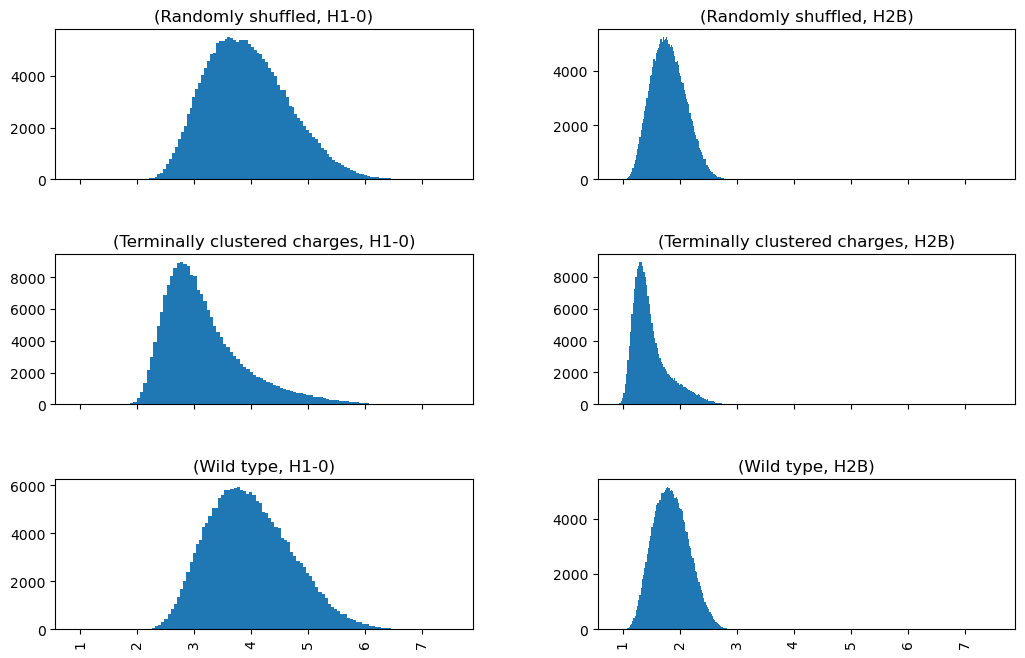

In [4]:
# Calculating Rg
initial['Rg'] = initial.apply(lambda row: analyse_utils.compute_rg(row['sequence'], row['traj']), axis=1)

# Plotting Rg distributions
initial_rg = initial.explode('Rg')
initial_rg['Rg'] = initial_rg['Rg'].astype(float)

# Plotting distributions
initial_rg.hist(column='Rg', by=['variant', 'template'], layout=(3,2), sharex=True, figsize=(12,8), bins=100)

# Calculating means
print("MEAN VALUES OF Rg")
means = initial_rg.groupby(by=['template', 'variant'])['Rg'].mean()
print(means*1e3)
print("ERROR OF THE MEAN OF Rg")
errors = initial_rg.groupby(by=['template', 'variant'])['Rg'].std(ddof=1)/np.sqrt(initial_rg.groupby(by=['template', 'variant'])['Rg'].count())
print(errors*1e3)

### Asphericity-distribution of variants

array([[<Axes: title={'center': '(Randomly shuffled, H1-0)'}>,
        <Axes: title={'center': '(Randomly shuffled, H2B)'}>],
       [<Axes: title={'center': '(Terminally clustered charges, H1-0)'}>,
        <Axes: title={'center': '(Terminally clustered charges, H2B)'}>],
       [<Axes: title={'center': '(Wild type, H1-0)'}>,
        <Axes: title={'center': '(Wild type, H2B)'}>]], dtype=object)

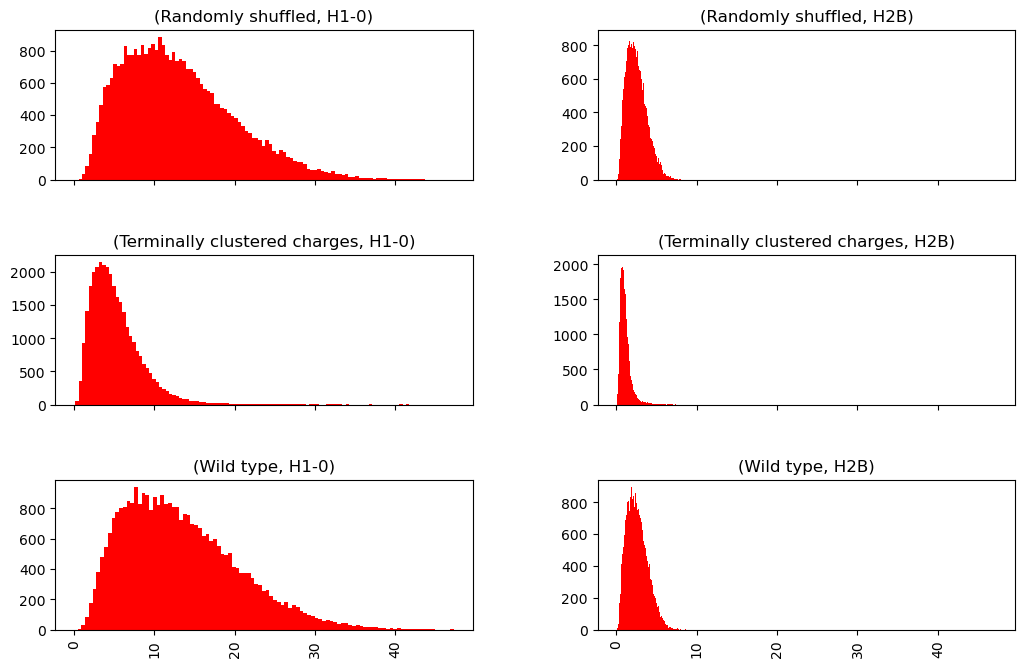

In [21]:
# Calculating asphericity
initial['b'] = initial.apply(lambda row: md.asphericity(row.traj), axis=1)

# Plotting b distributions
initial_b = initial.explode('b')
initial_b['b'] = initial_b['b'].astype(float)

# Plotting distributions
initial_b.hist(column='b', by=['variant', 'template'], layout=(3,2), sharex=True, figsize=(12,8), bins=100, color='r')

### Acylindricity-distribution of variants

array([[<Axes: title={'center': '(Randomly shuffled, H1-0)'}>,
        <Axes: title={'center': '(Randomly shuffled, H2B)'}>],
       [<Axes: title={'center': '(Terminally clustered charges, H1-0)'}>,
        <Axes: title={'center': '(Terminally clustered charges, H2B)'}>],
       [<Axes: title={'center': '(Wild type, H1-0)'}>,
        <Axes: title={'center': '(Wild type, H2B)'}>]], dtype=object)

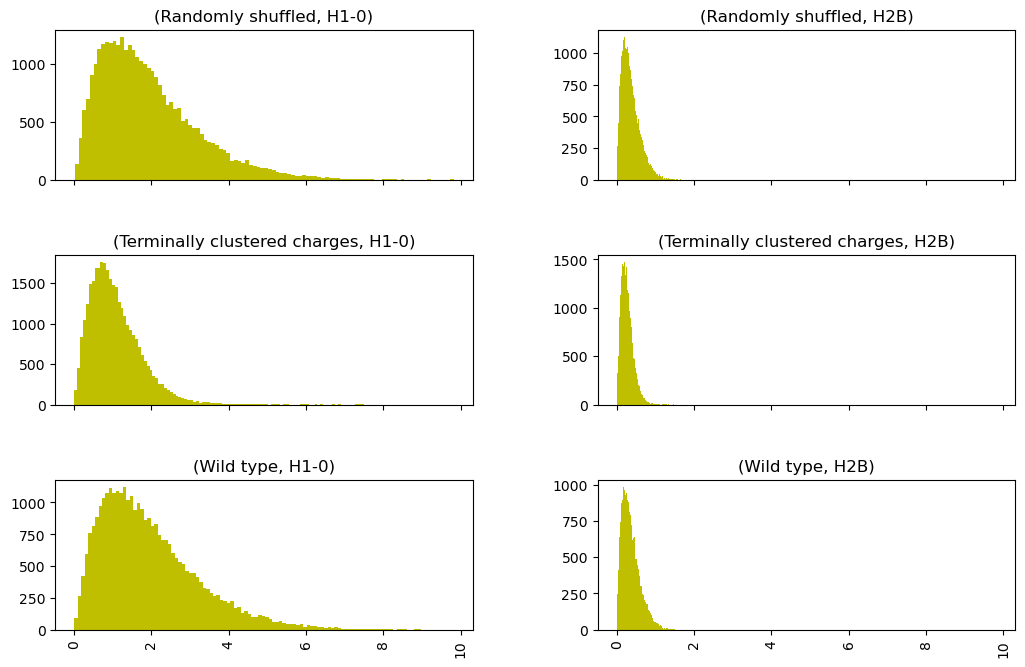

In [22]:
# Calculating acylindricity
initial['c'] = initial.apply(lambda row: md.acylindricity(row.traj), axis=1)

# Plotting b distributions
initial_c = initial.explode('c')
initial_c['c'] = initial_c['c'].astype(float)

# Plotting distributions
initial_c.hist(column='c', by=['variant', 'template'], layout=(3,2), sharex=True, figsize=(12,8), bins=100, color='y')

### Anisotropy-distribution of variants

array([[<Axes: title={'center': '(Randomly shuffled, H1-0)'}>,
        <Axes: title={'center': '(Randomly shuffled, H2B)'}>],
       [<Axes: title={'center': '(Terminally clustered charges, H1-0)'}>,
        <Axes: title={'center': '(Terminally clustered charges, H2B)'}>],
       [<Axes: title={'center': '(Wild type, H1-0)'}>,
        <Axes: title={'center': '(Wild type, H2B)'}>]], dtype=object)

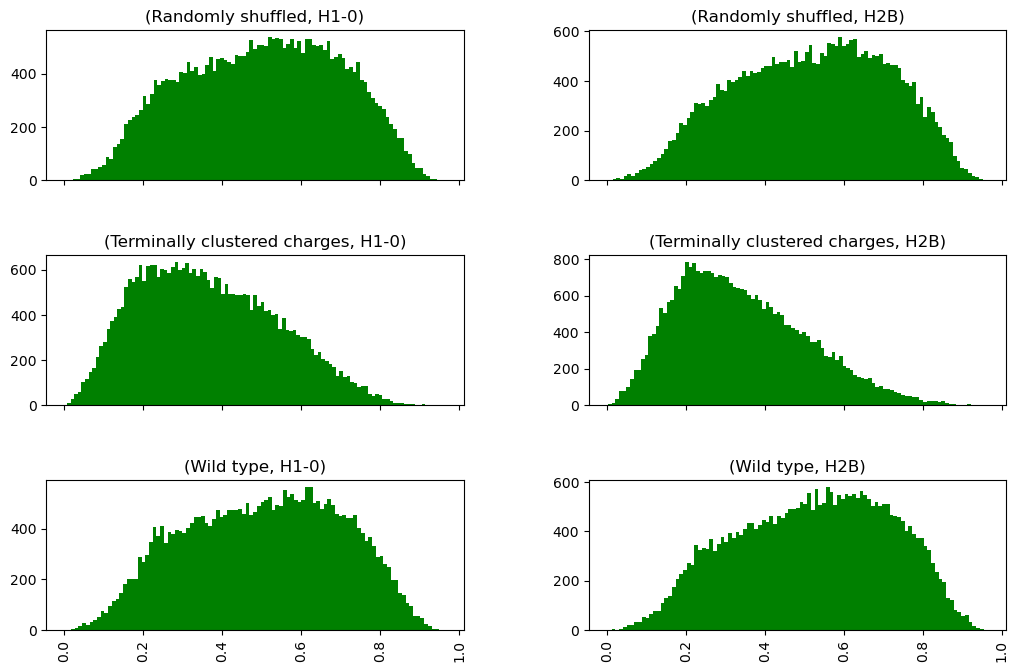

In [24]:
# Calculating anisotropy k
initial['k'] = initial.apply(lambda row: md.relative_shape_antisotropy(row.traj), axis=1)

# Plotting k distributions
initial_k = initial.explode('k')
initial_k['k'] = initial_k['k'].astype(float)

# Plotting distributions
initial_k.hist(column='k', by=['variant', 'template'], layout=(3,2), sharex=True, figsize=(12,8), bins=100, color='g')

### End-to-end distance distribution

array([[<Axes: title={'center': '(Randomly shuffled, H1-0)'}>,
        <Axes: title={'center': '(Randomly shuffled, H2B)'}>],
       [<Axes: title={'center': '(Terminally clustered charges, H1-0)'}>,
        <Axes: title={'center': '(Terminally clustered charges, H2B)'}>],
       [<Axes: title={'center': '(Wild type, H1-0)'}>,
        <Axes: title={'center': '(Wild type, H2B)'}>]], dtype=object)

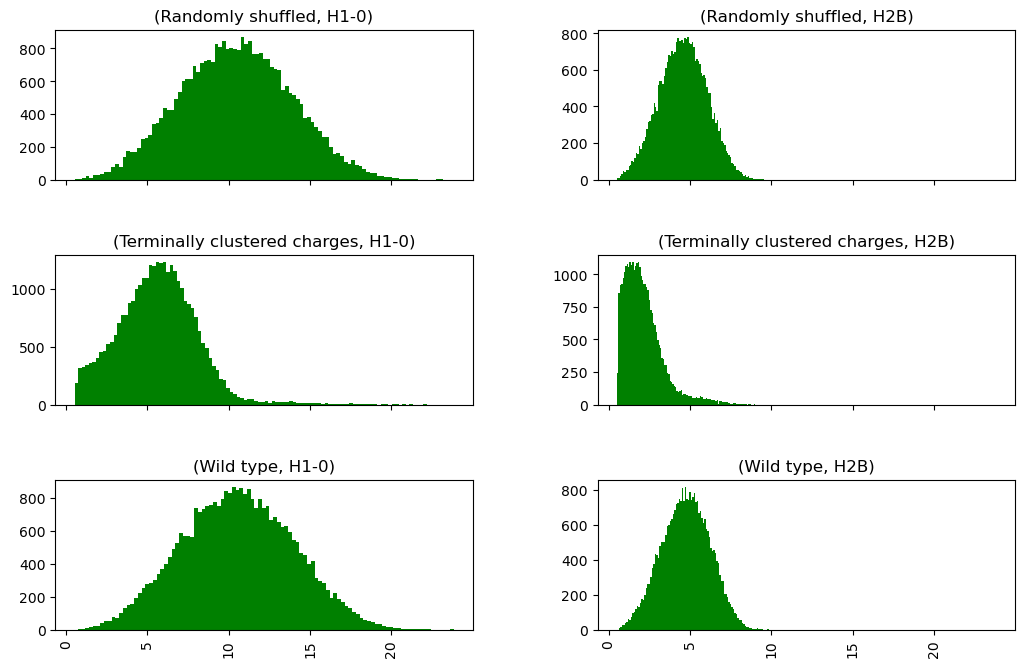

In [45]:
# Calculating end to end distances
initial['ee'] = initial.apply(lambda row: md.compute_distances(row.traj, [[0, row.traj.n_atoms-1]]), axis=1)

# Plotting end to end distributions
initial_ee = initial.explode('ee')
initial_ee['ee'] = initial_ee['ee'].astype(float)

# Plotting distributions
initial_ee.hist(column='ee', by=['variant', 'template'], layout=(3,2), sharex=True, figsize=(12,8), bins=100, color='g')

### Contact map

In [4]:
# Seleting one trajectory
H1WT = initial.loc['H1-0_WT', 'traj']

In [5]:
# Calculating contact map
residue_pairs = np.array([np.array([i,j]) for i in range(H1WT.n_residues) for j in range(i+1, H1WT.n_residues)])
contacts = md.geometry.squareform(*md.compute_contacts(H1WT, residue_pairs))

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_24881/1822812605.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(data))
 20%|██        | 20/100 [00:15<00:55,  1.44it/s]/tmp/ipykernel_24881/1822812605.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


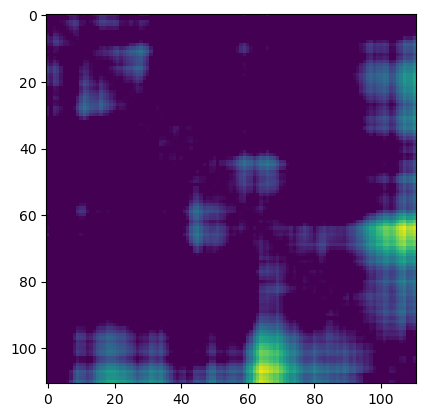

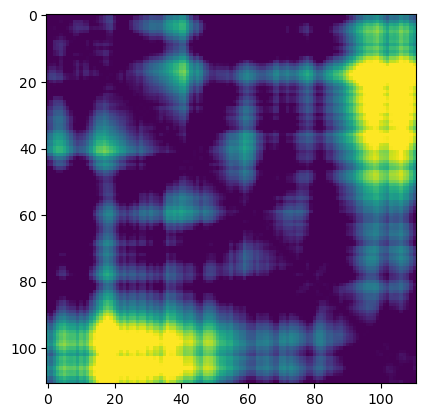

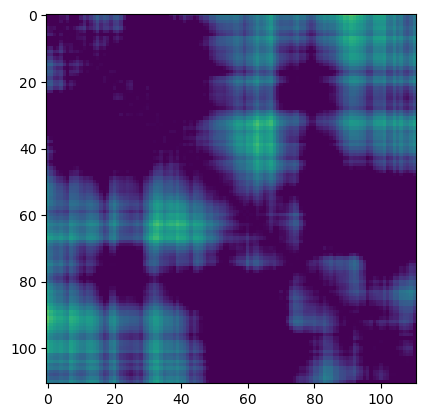

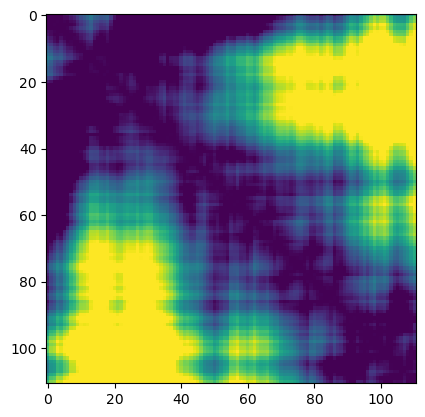

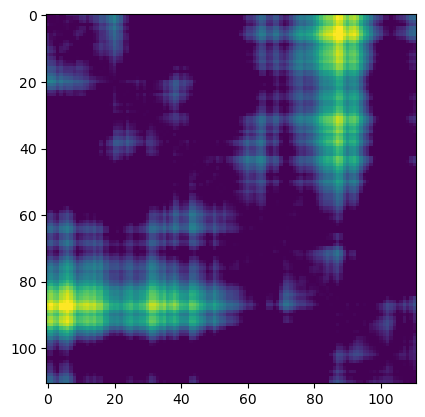

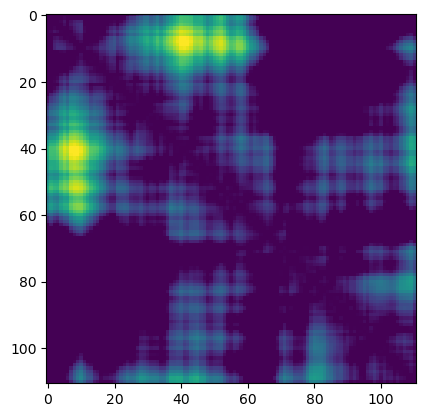

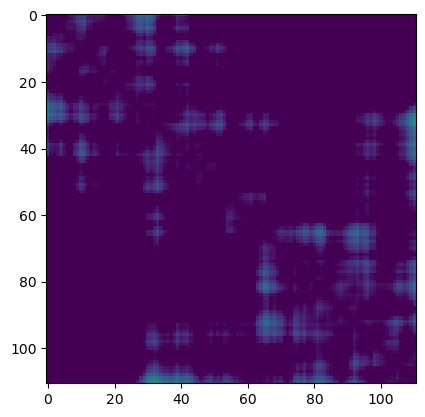

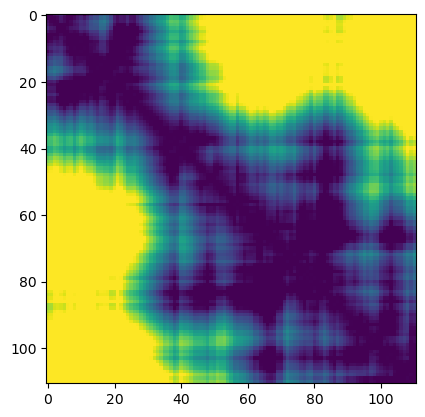

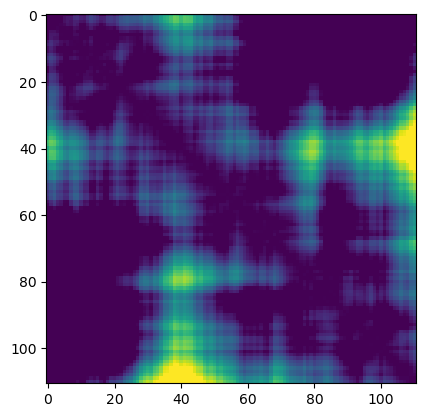

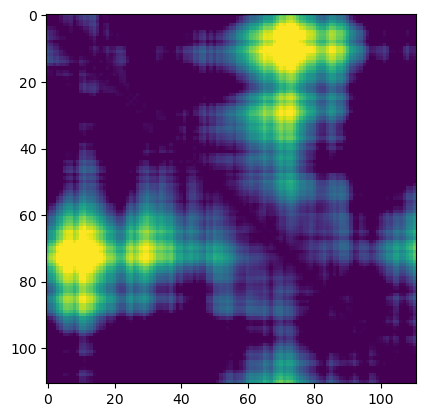

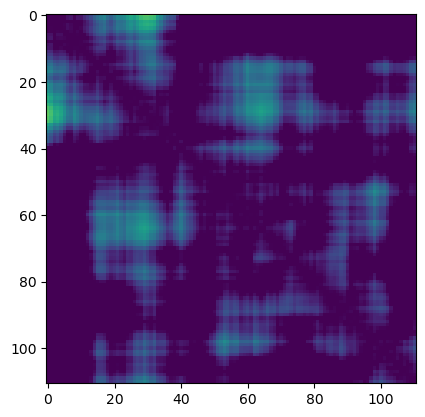

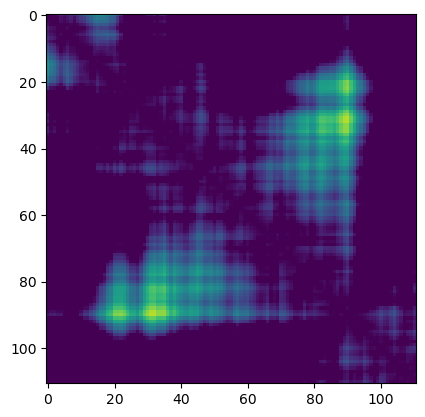

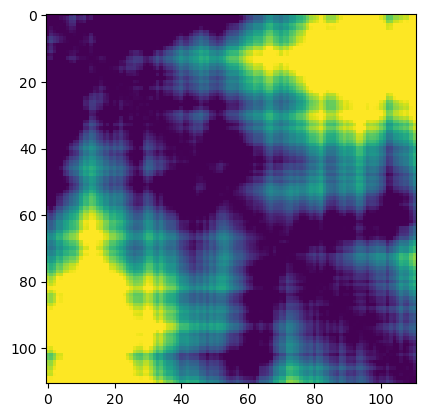

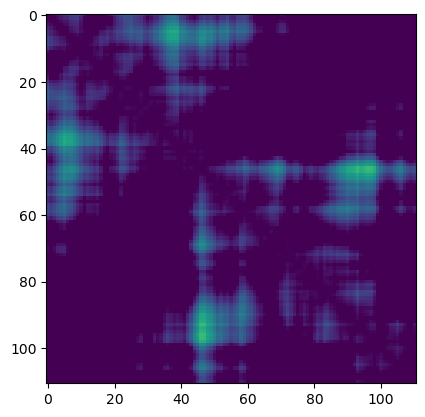

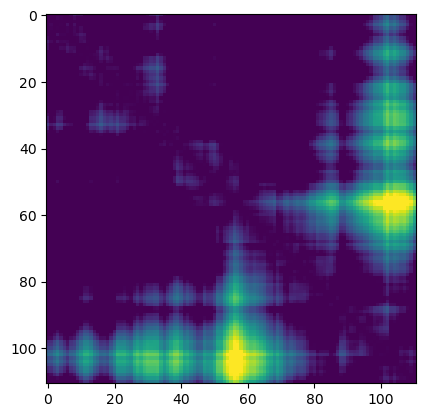

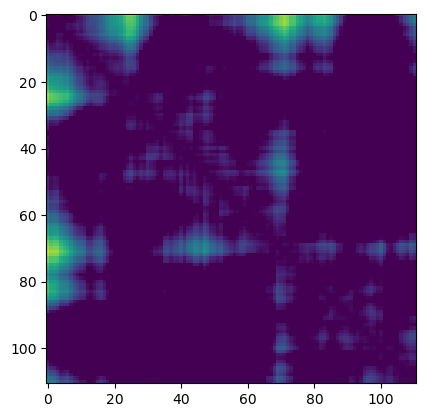

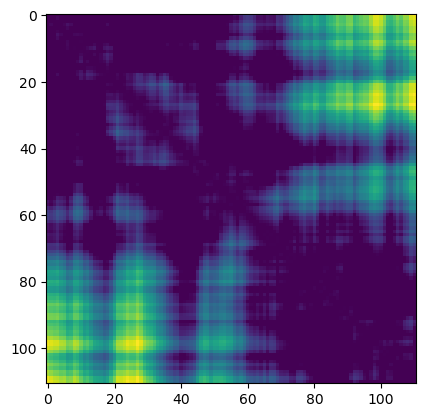

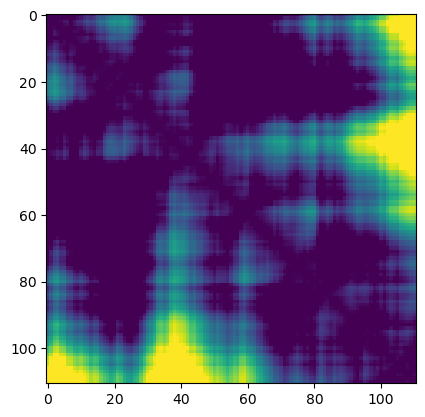

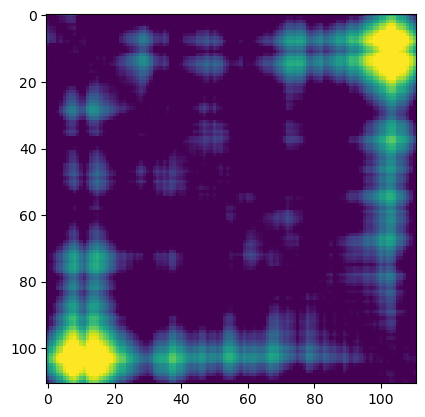

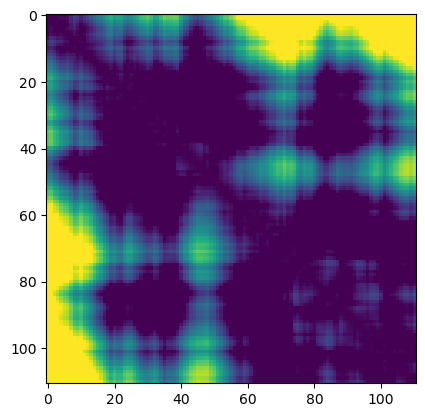

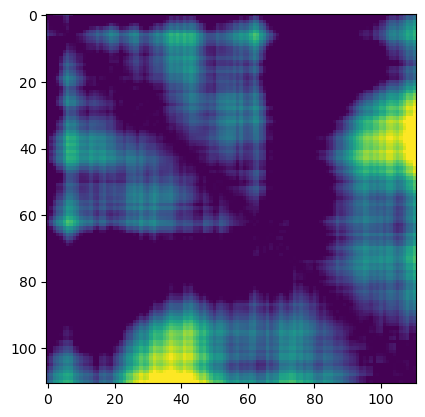

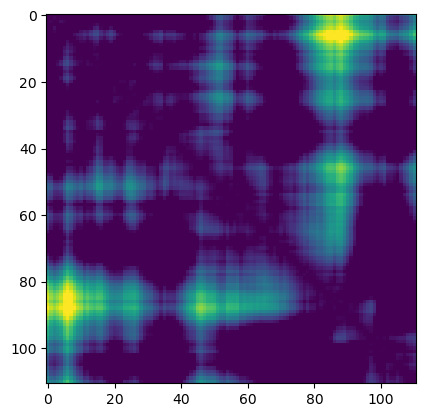

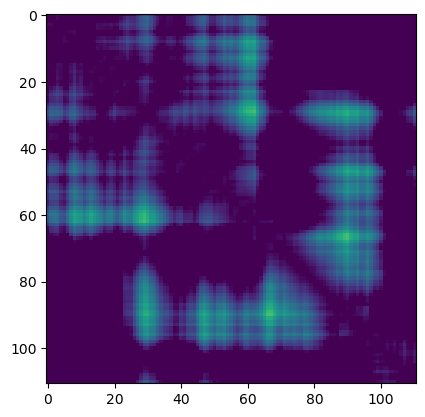

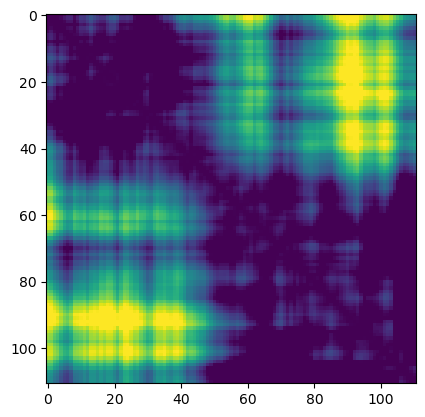

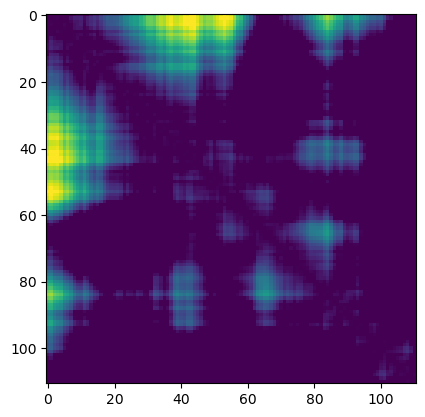

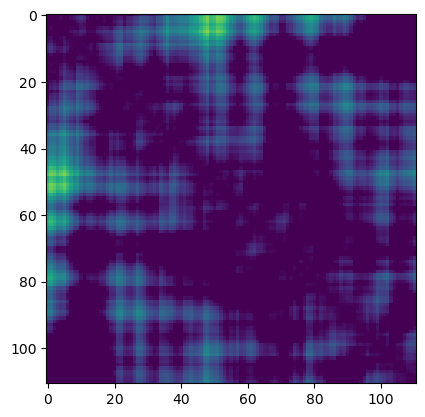

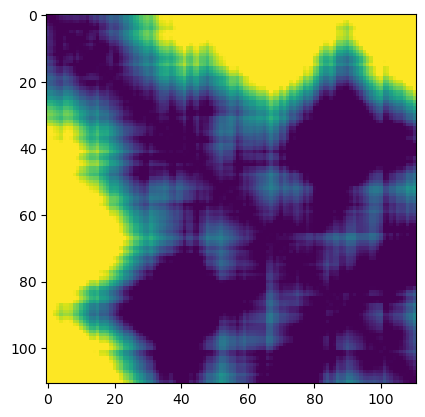

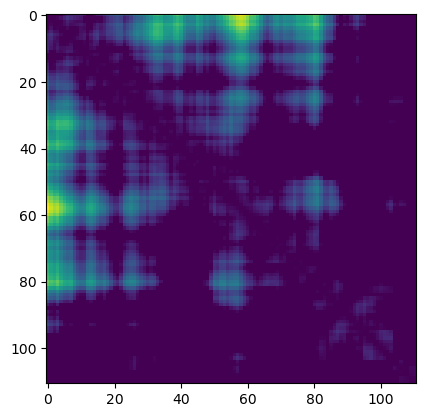

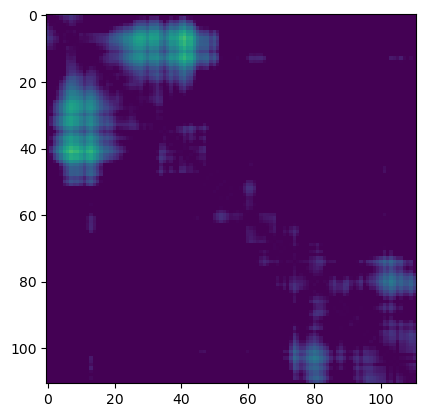

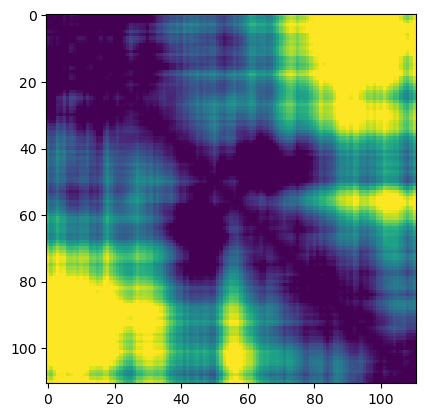

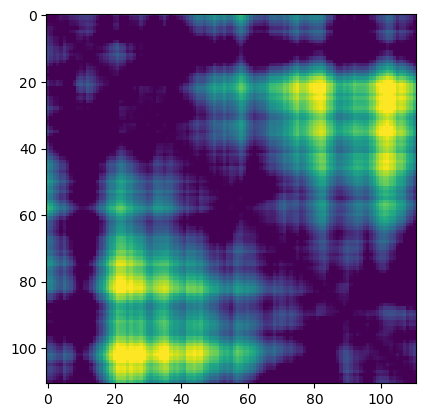

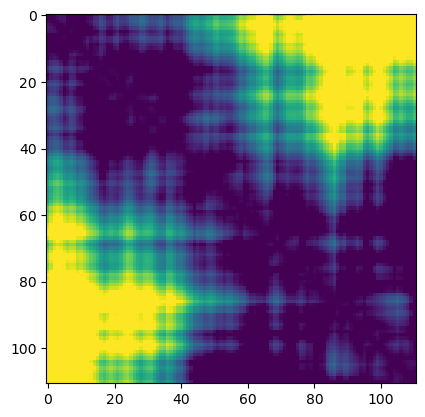

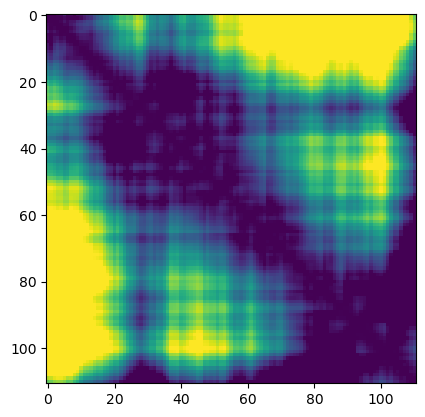

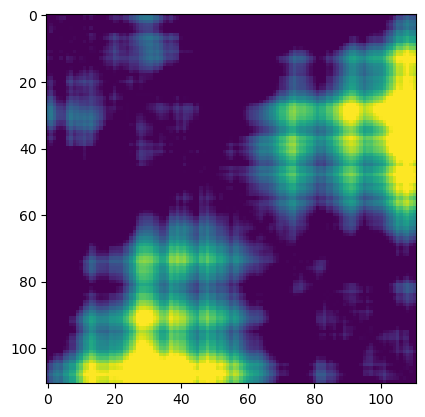

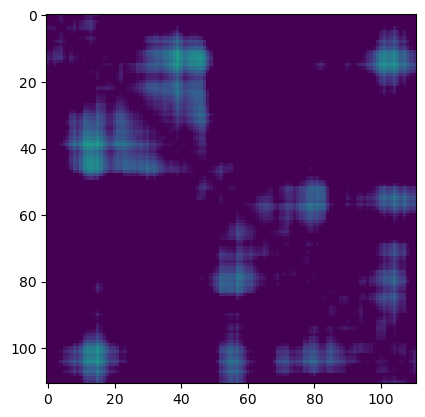

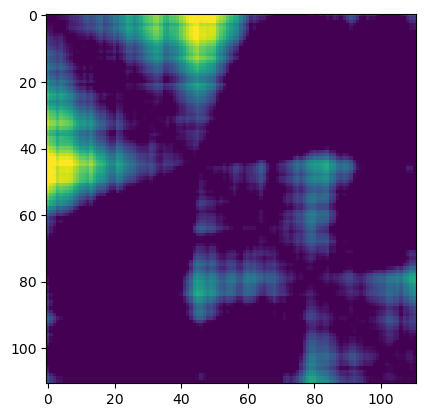

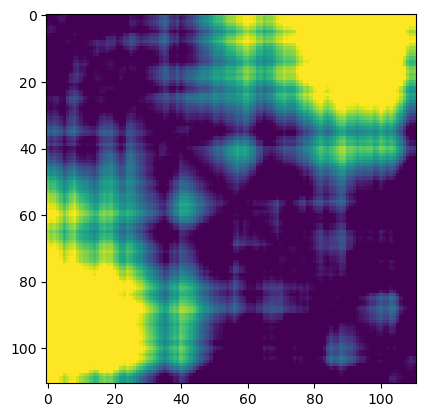

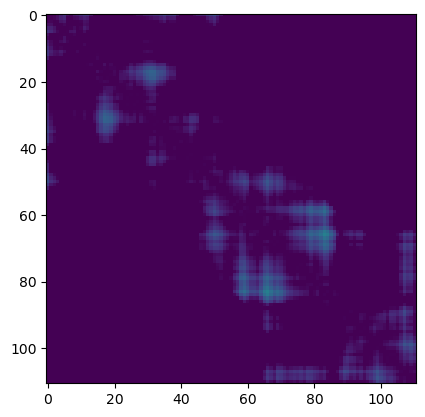

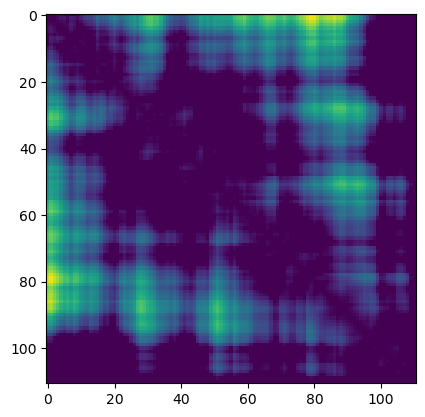

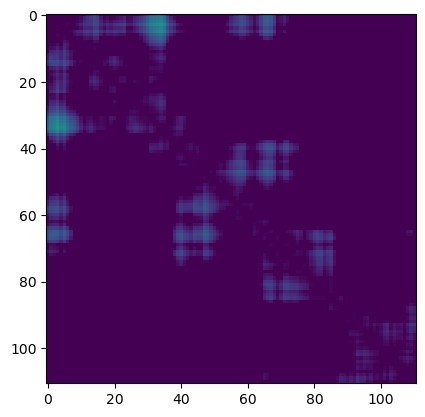

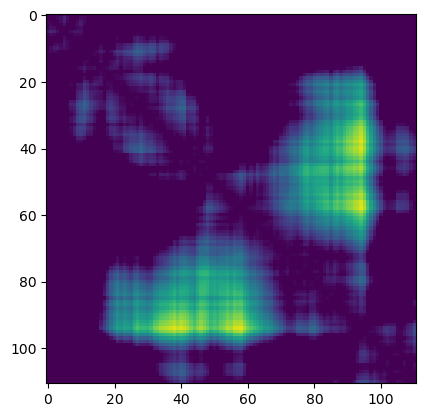

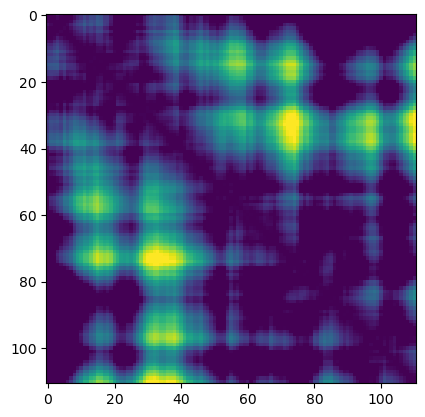

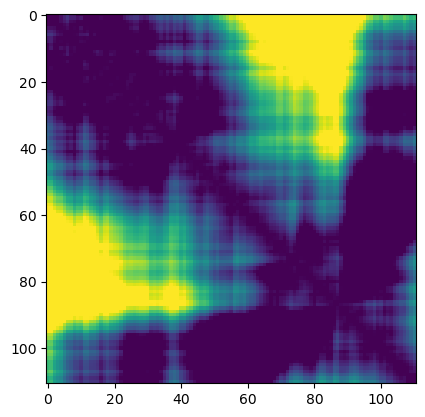

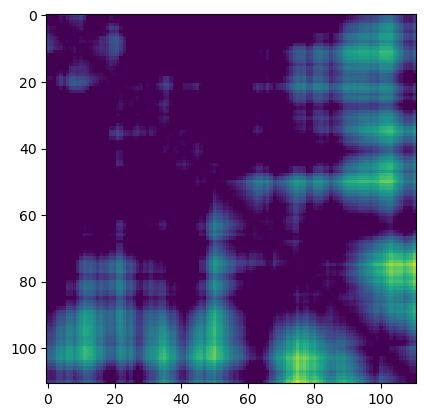

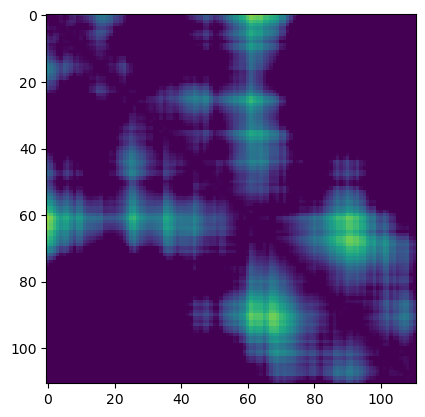

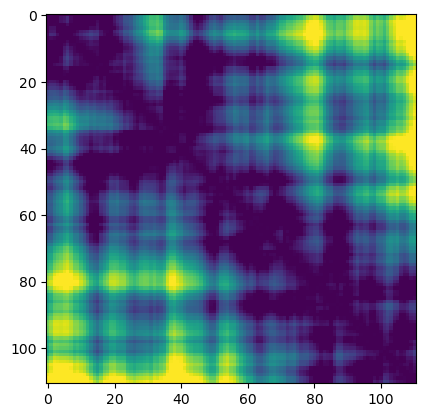

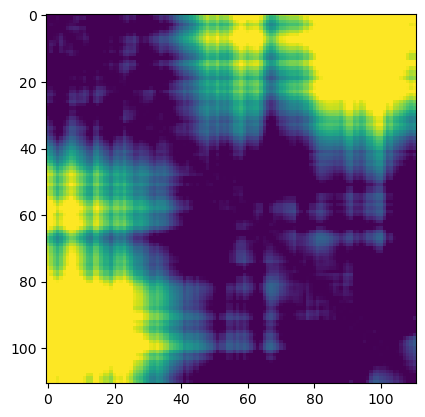

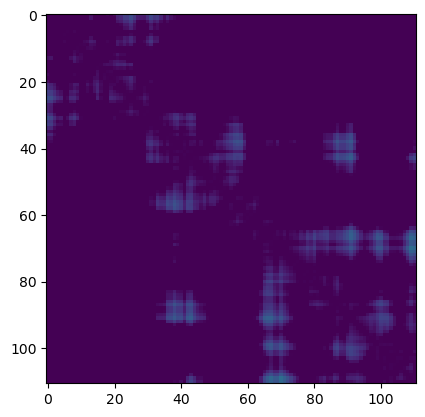

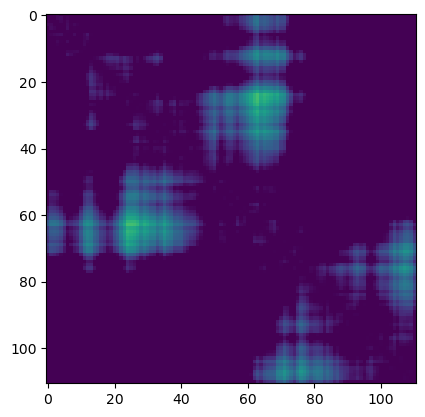

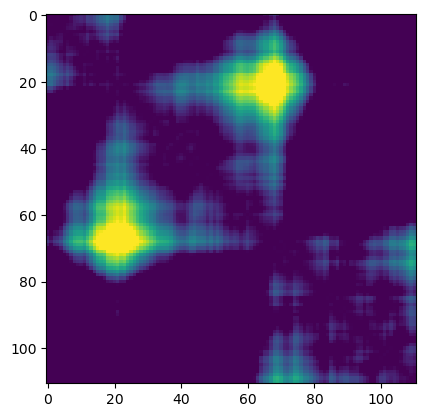

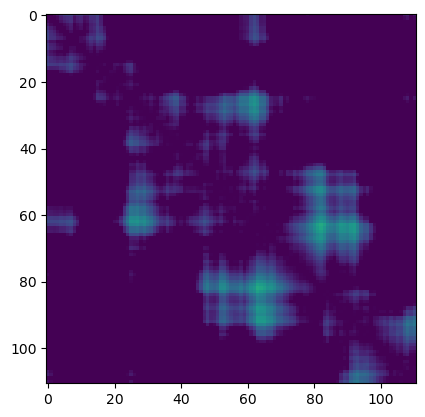

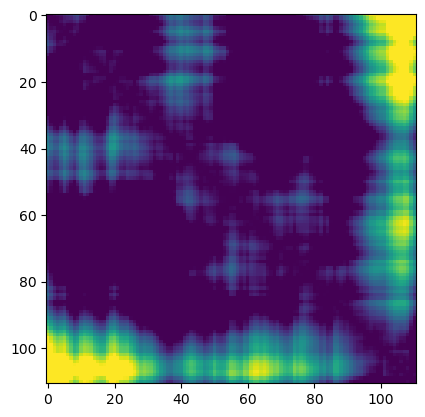

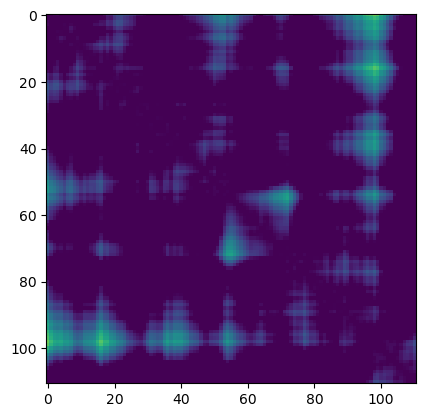

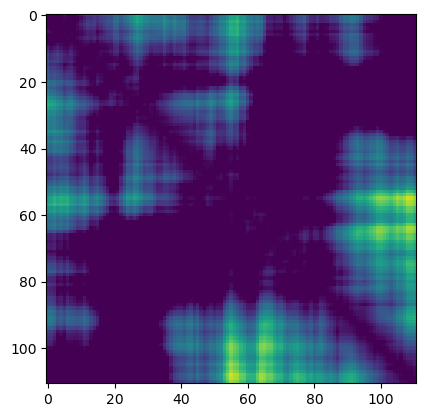

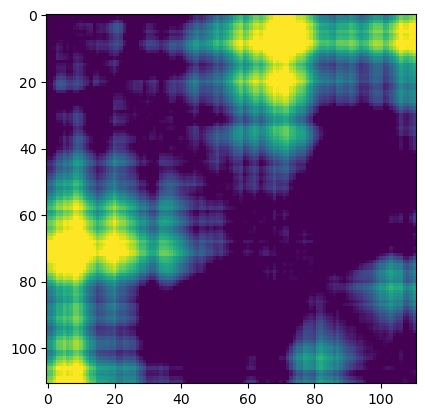

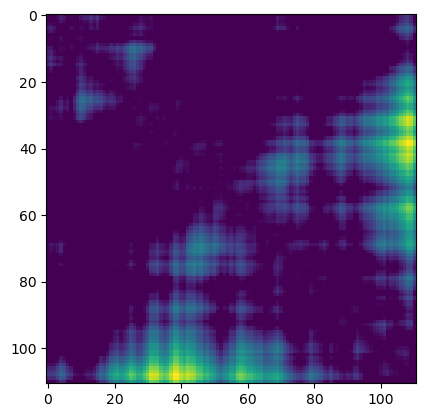

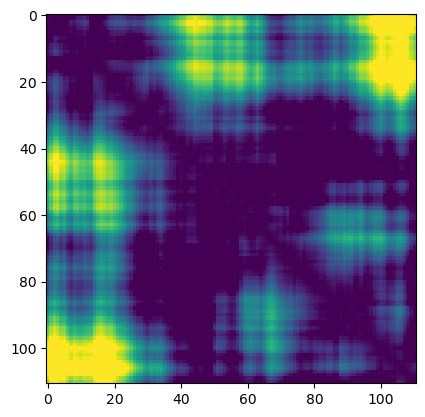

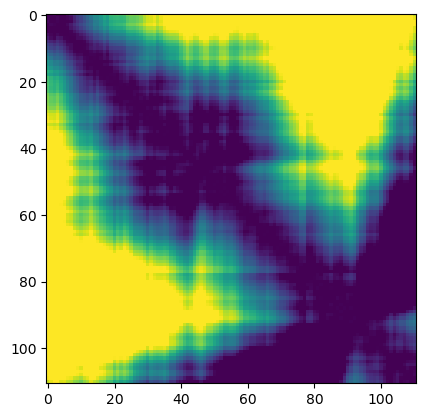

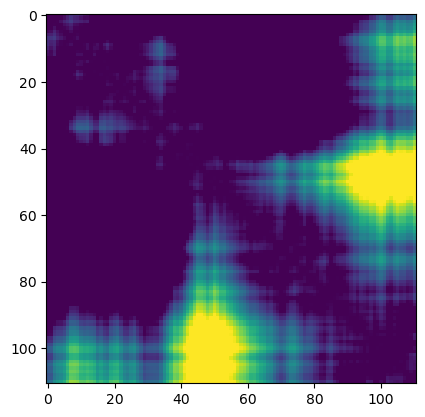

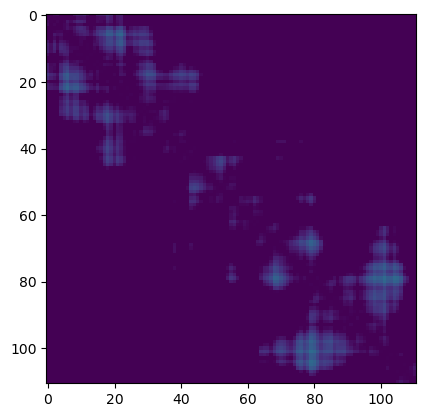

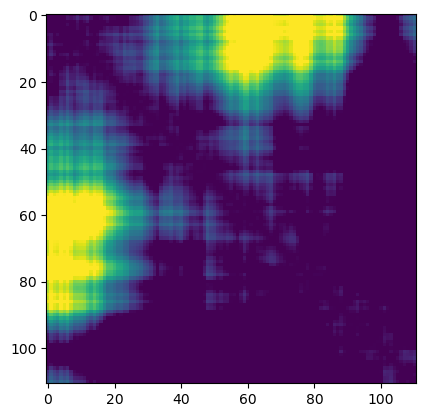

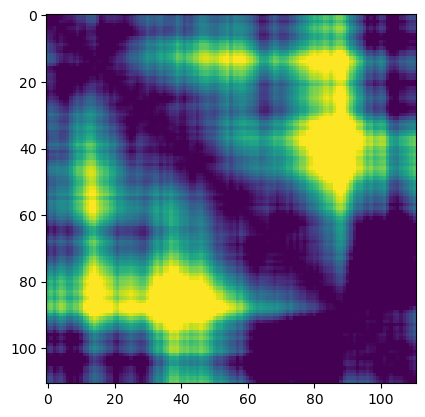

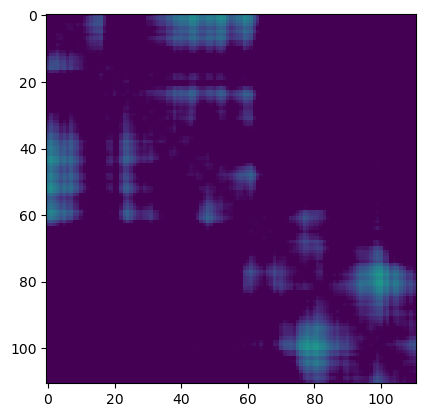

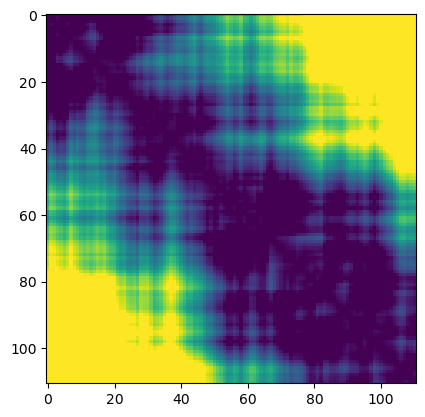

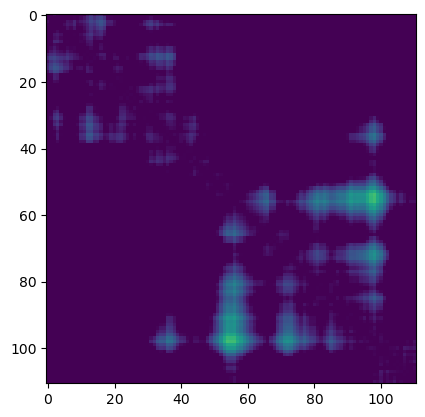

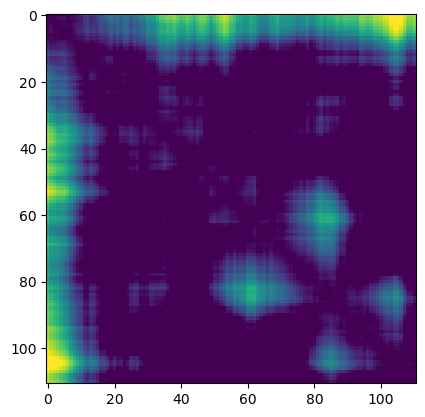

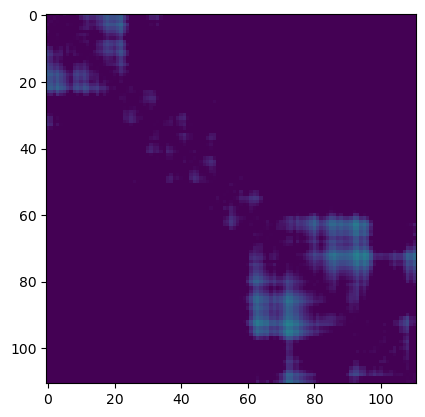

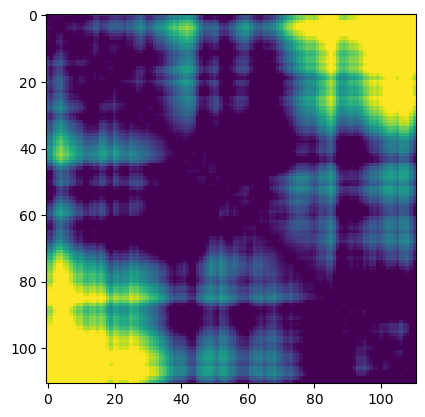

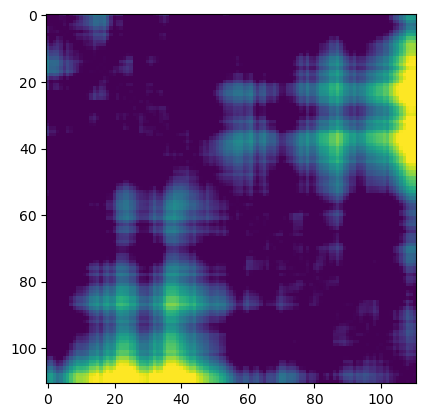

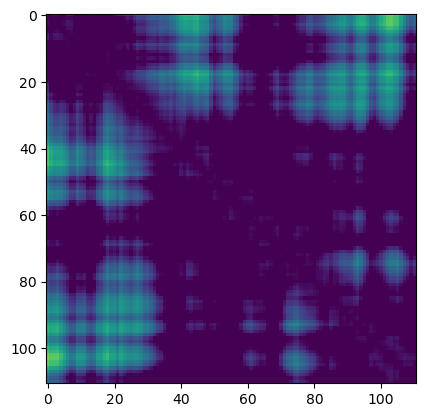

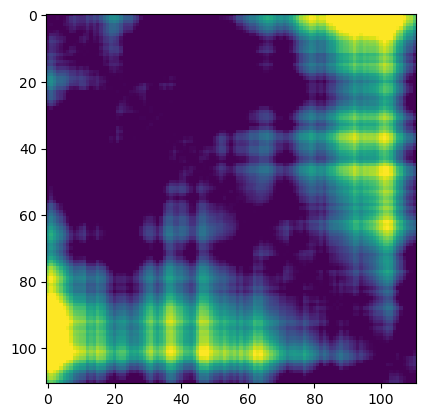

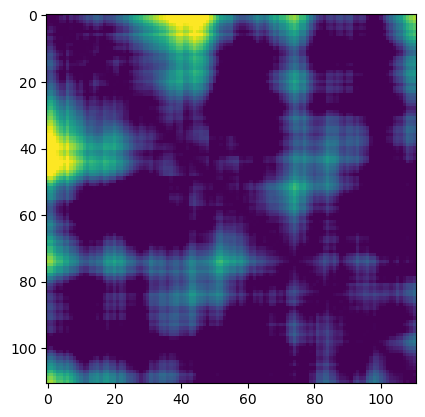

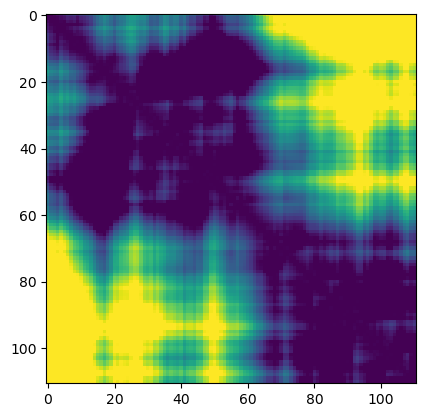

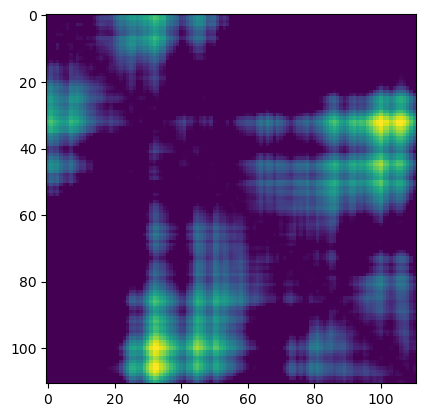

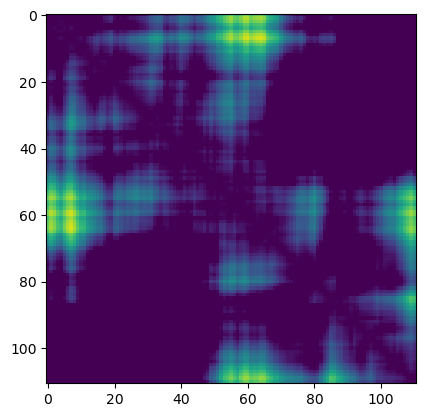

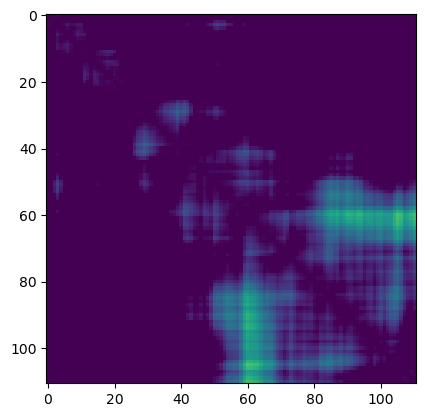

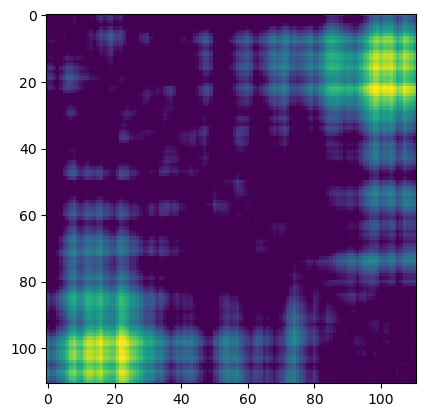

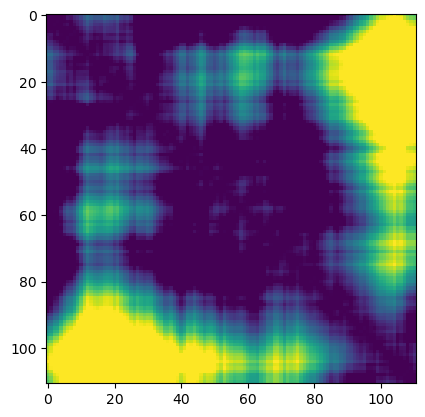

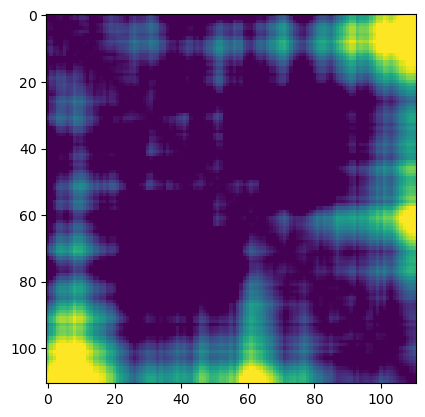

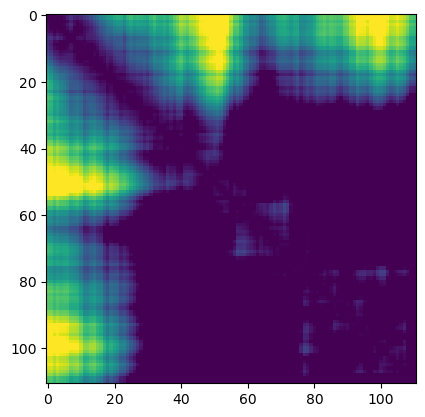

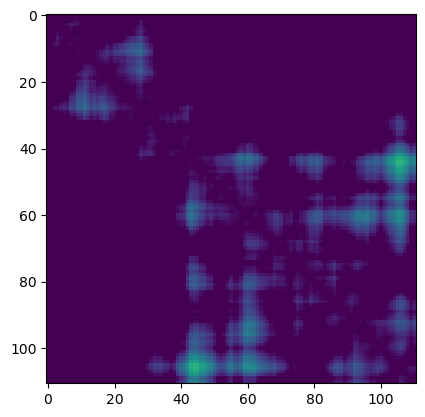

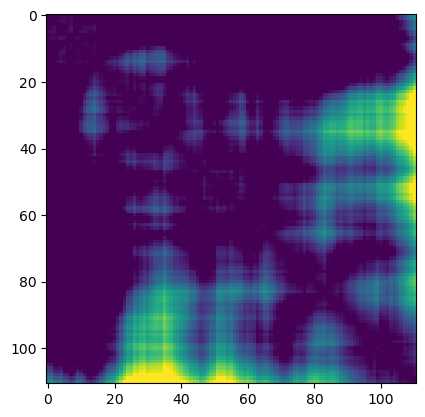

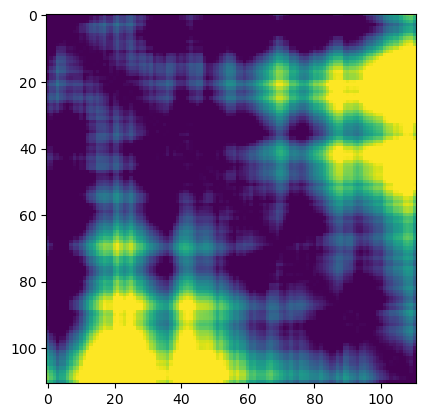

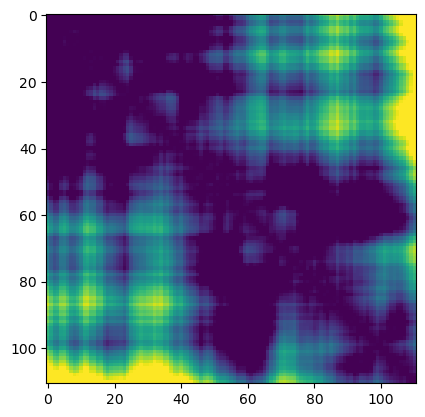

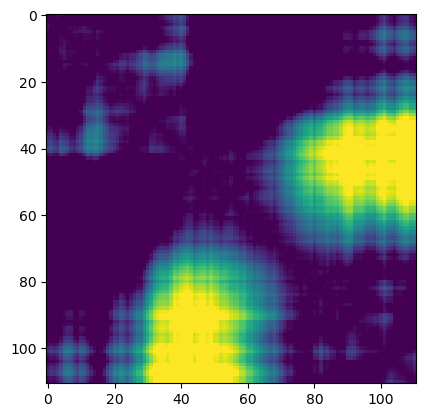

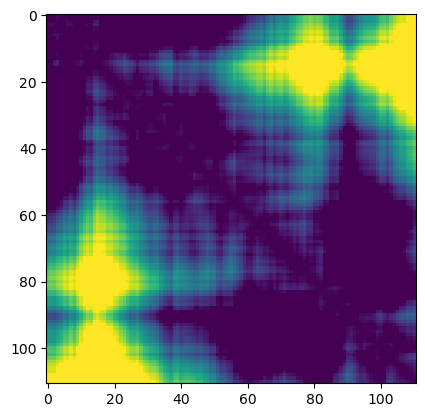

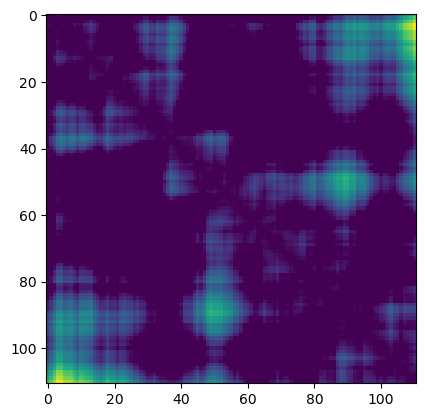

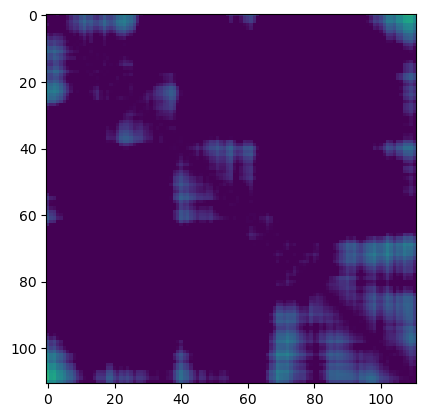

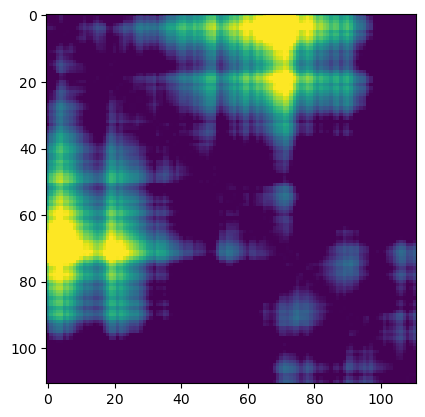

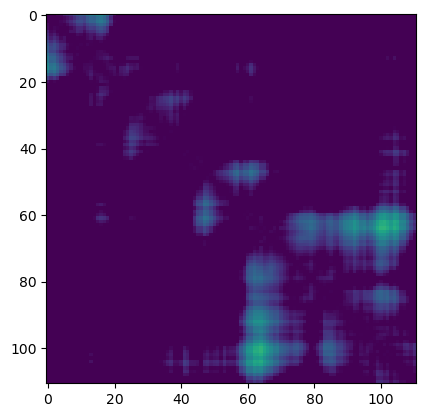

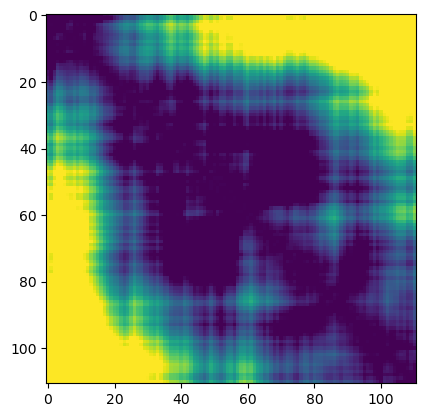

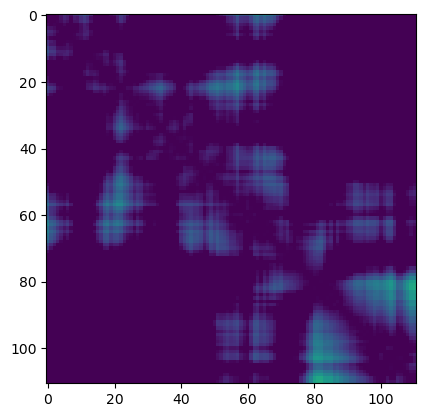

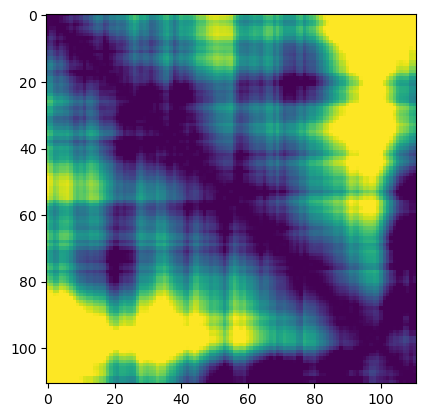

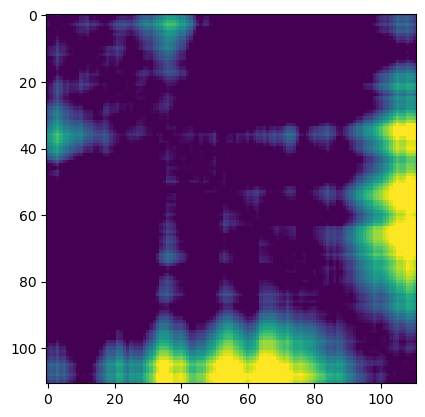

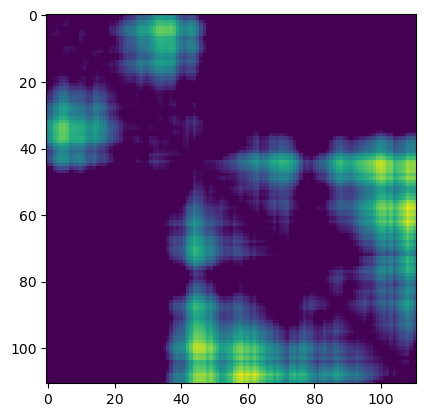

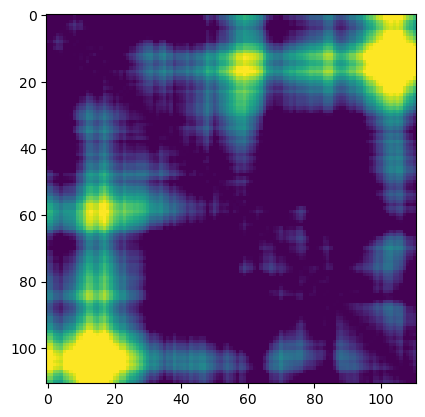

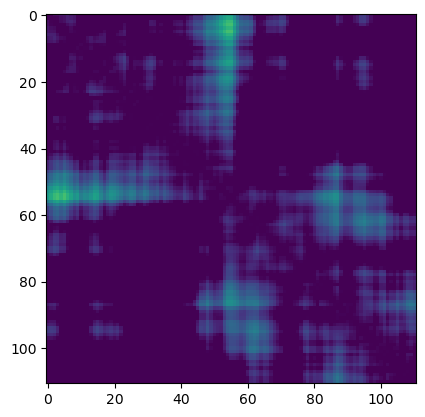

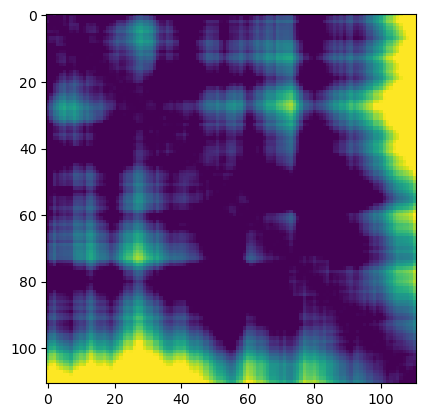

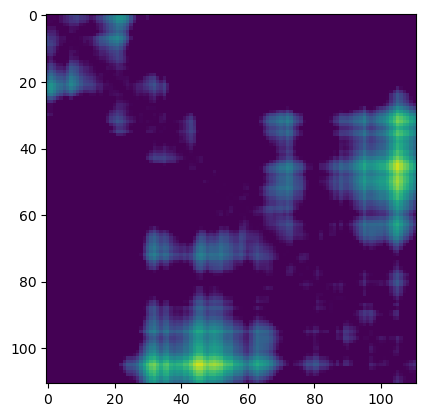

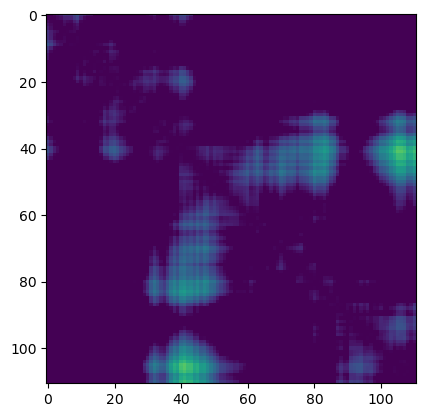

In [7]:
# Creating gif
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from tqdm import tqdm
import io
import imageio

images = []
time = 10 # s
frames = 100 # framess

for t in tqdm(np.linspace(0, 1000, frames)):
    fig, ax = plt.subplots()
    ax.imshow(contacts[round(t)] - contacts.mean(axis=0), vmin=0, vmax=1)
    canvas = FigureCanvas(fig)
    buf = io.BytesIO()
    canvas.print_png(buf)
    data = buf.getvalue()
    images.append(imageio.imread(data))

imageio.mimsave('my_gif.gif', images, duration=time/frames)

## Histone H1.0 Orthologs

In [59]:
# Loading metadata
ortho = analyse_utils.load_metadata('exp/ortho_h1-0/ortho_h1-0.json')

ortho

template                                           sequence  \
0_9TELE      0_9TELE  HTKGIGASGSFRLTKPEDSSKKPAKAAAAVAAKPKKVAKAKPKKAA...   
1_CYPVA      1_CYPVA  RHTKGIGASGSFRLTKPEDTKKPAAKAASAPKPKKVVKPKPKKAAK...   
2_FUNHE      2_FUNHE  RHTKGIGASGSFRLTKPEDTKKTPAKAASAAKPRKVAKPKPKKAAK...   
3_KRYMA      3_KRYMA  HTKGIGASGSFRLTKPEDSSKKPAKAAAAAASAKPKKVAKPKPKKA...   
4_NOTFU      4_NOTFU  RHTKGIGASGSFRLTKPEDSKKPAKAAASAKPKKVAKPKPKKAAKP...   
...              ...                                                ...   
191_NECAM  191_NECAM            RKEVVRKEAAQKAKPTRNTTGSSSRKTVKSVKKSTASRV   
192_STRRB  192_STRRB  KKSSEAKKVTDSKKSTDVKKTPETKKAVKAPKAKATEKKVLKKAIV...   
193_CAPO3  193_CAPO3  AAALPKAAKAPKAAKAPKAEKPAKAAKAPKADKPAKAAKAPKAAKA...   
194_STRPU  194_STRPU  RHVKGSGASGSFLLAEKTKTPKKAAAKKATPKKKPAAKKTKKPAAK...   
195_TRIAD  195_TRIAD  KVEKPKKKKVVKKKPAAKKPAKKTKPKTKKAASPKKAAKKPAAKKD...   

          location region    variant                              description  \
0_9TELE     80:197    CTD  Wild type                           histone H1.0-B   
1_CYPVA     78:194    CTD  Wild type                           Histone H1.0-B   
2_FUNHE     79:195    CTD  Wild type                           Histone H1.0-B   
3_KRYMA     80:198    CTD  Wild type                           Histone H1.0-B   
4_NOTFU     79:194    CTD  Wild type              H1 histone family, member 0   
...            ...    ...        ...                                      ...   
191_NECAM  168:207    CTD  Wild type  Linker histone H1 and H5 family protein   
192_STRRB  138:221    CTD  Wild type                             Histone H1.0   
193_CAPO3  213:355    CTD  Wild type            H15 domain-containing protein   
194_STRPU   89:185    CTD  Wild type                         Histone H1-delta   
195_TRIAD   96:190    CTD  Wild type            H15 domain-containing protein   

                                                     species  \
0_9TELE                              Austrofundulus limnaeus   
1_CYPVA            Cyprinodon variegatus (Sheepshead minnow)   
2_FUNHE                    Fundulus heteroclitus (Killifish)   
3_KRYMA         Kryptolebias marmoratus (Mangrove killifish)   
4_NOTFU         Nothobranchius furzeri (Turquoise killifish)   
...                                                      ...   
191_NECAM                Necator americanus (Human hookworm)   
192_STRRB          Strongyloides ratti (Parasitic roundworm)   
193_CAPO3          Capsaspora owczarzaki (strain ATCC 30864)   
194_STRPU  Strongylocentrotus purpuratus (Purple sea urchin)   
195_TRIAD          Trichoplax adhaerens (Trichoplax reptans)   

                       name  uniprot_id  
0_9TELE    A0A2I4B7C3_9TELE  A0A2I4B7C3  
1_CYPVA    A0A3Q2C803_CYPVA  A0A3Q2C803  
2_FUNHE    A0A3Q2Q6G9_FUNHE  A0A3Q2Q6G9  
3_KRYMA    A0A3Q3AJ14_KRYMA  A0A3Q3AJ14  
4_NOTFU    A0A1A8V9N7_NOTFU  A0A1A8V9N7  
...                     ...         ...  
191_NECAM      W2TEX0_NECAM      W2TEX0  
192_STRRB  A0A090KXU4_STRRB  A0A090KXU4  
193_CAPO3  A0A0D2VKG3_CAPO3  A0A0D2VKG3  
194_STRPU         H1D_STRPU      P15870  
195_TRIAD      B3RQA0_TRIAD      B3RQA0  

[190 rows x 9 columns]

### CIDER parameters for input data

More on CIDER from Pappu Lab:
- [CIDER](http://pappulab.wustl.edu/CIDER/about/)
- [localCIDER](http://pappulab.github.io/localCIDER/)

In [61]:
# Calculating parameters
params = analyse_utils.cider_parameters(ortho['sequence'])

# Adding length
params['Length'] = ortho['sequence'].str.len()

# Presenting documentation and results
params.sort_values(by='kappa')

kappa       FCR      NCPR  Hydrophobicity  Frac. dis. prom.  \
175_ECTSI  0.065010  0.469880  0.445783        3.153012          0.879518   
179_POMCA  0.073321  0.397959  0.397959        3.468367          0.969388   
180_POMCA  0.091011  0.378641  0.378641        3.589320          0.951456   
193_CAPO3  0.091084  0.394366  0.253521        3.490141          0.978873   
34_ONCMY   0.098636  0.461538  0.423077        3.390385          0.884615   
...             ...       ...       ...             ...               ...   
188_LOALO  0.184397  0.474576  0.338983        2.750847          0.881356   
184_POCDA  0.192282  0.527174  0.201087        2.597826          0.869565   
135_OCTDE  0.199832  0.393617  0.287234        3.159574          0.861702   
182_ACTTE  0.203189  0.518519  0.481481        2.600000          0.962963   
138_OCTDE  0.226661  0.389610  0.311688        3.215584          0.844156   

           Length  
175_ECTSI      83  
179_POMCA      98  
180_POMCA     103  
193_CAPO3     142  
34_ONCMY      104  
...           ...  
188_LOALO      59  
184_POCDA     184  
135_OCTDE      94  
182_ACTTE     108  
138_OCTDE      77  

[190 rows x 6 columns]

In [62]:
# Joining parameter results to metadata
ortho = ortho[list(set(ortho.columns) - set(params.columns))]
ortho = ortho.join(params)

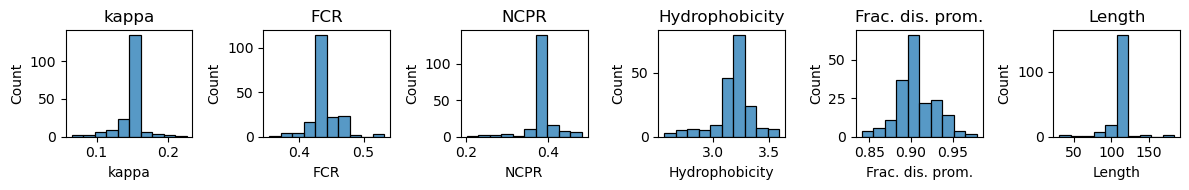

In [63]:
# Plotting CIDER parameters distribution
fig, axes = plt.subplots(ncols=len(params.columns), figsize=(12,2))

# Looping over subplots and parameters
for ax, col in zip(axes, params.columns):
    sns.histplot(data=params, x=col, bins=10, ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

### Amino acid content for input data

In [64]:
# Calculating frequencies
freqs = analyse_utils.amino_acid_content(ortho['sequence'])

In [65]:
# Joining frequency results to metadata
ortho = ortho[list(set(ortho.columns) - set(freqs.columns))]
ortho = ortho.join(freqs)

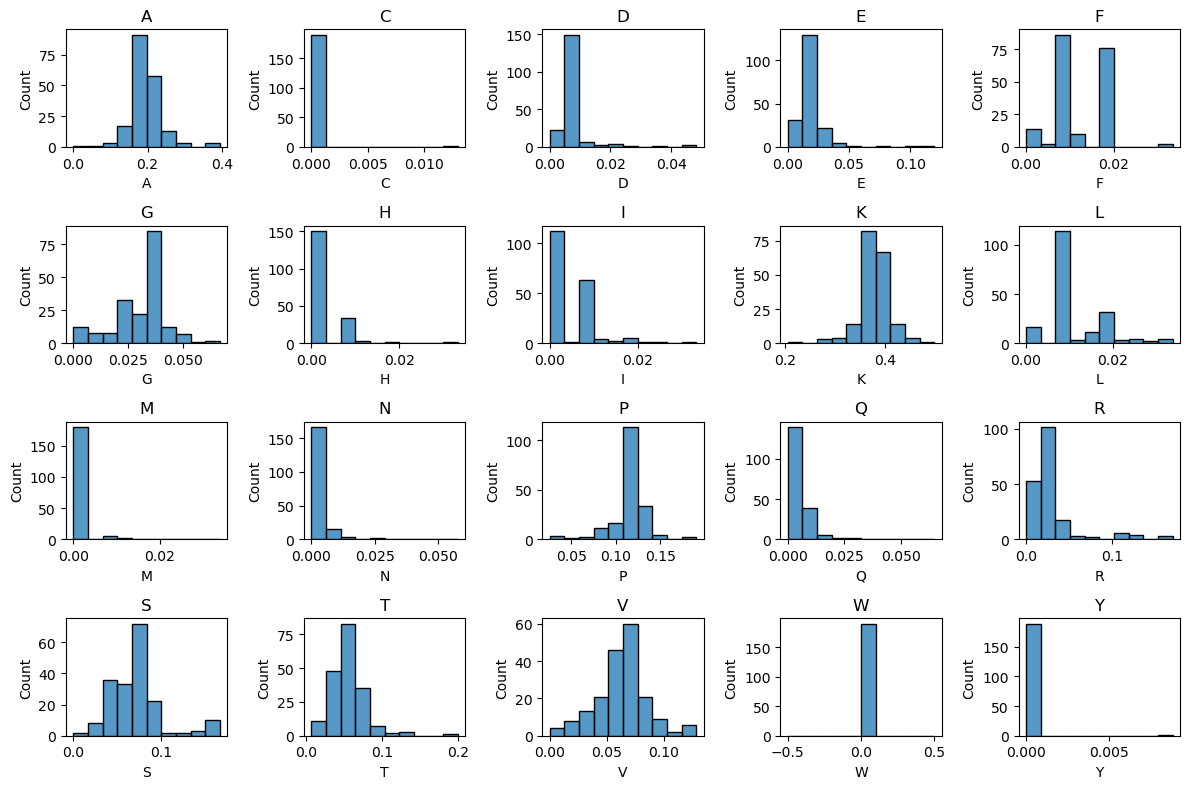

In [66]:
# Plotting distributions
# Setting plot dimensions
dimensions = (4,5)
fig, axes = plt.subplots(*dimensions, figsize=(12,8))
amino_acids = np.reshape(analyse_utils.amino_acids, dimensions)

# Looping over subplots and amino acids
for i in range(dimensions[0]):
    for j in range(dimensions[1]):
        ax = axes[i,j]
        aa = amino_acids[i,j]
        sns.histplot(data=freqs, x=aa, bins=10, ax=ax)
        ax.set_title(aa)

plt.tight_layout()
plt.show()

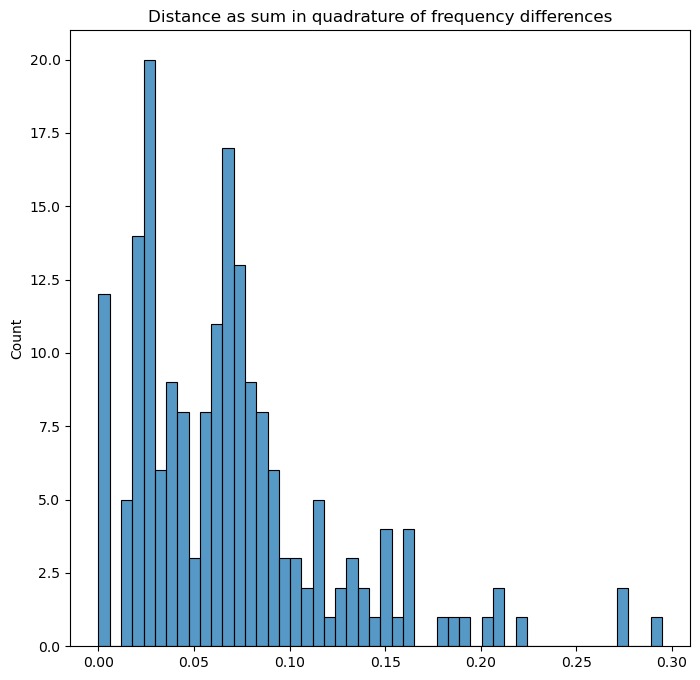

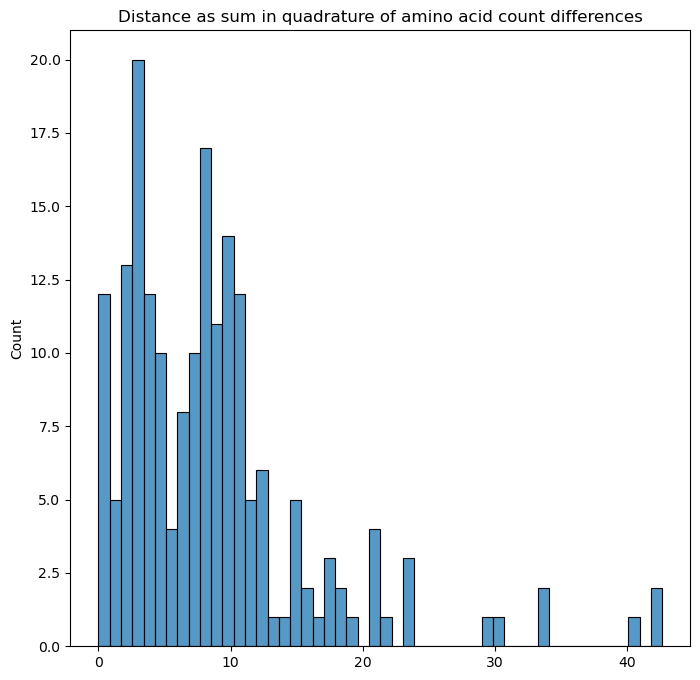

In [67]:
# Calculating sequence distance
# Setting reference sequence
i_ref = ortho[ortho['species'].str.contains('Human')].index[0]

# Method 1: Distance as sum in quadrature of frequency differences
freq_diff = (freqs - freqs.loc[i_ref])**2
freq_diff = np.sqrt(freq_diff.sum(axis=1))
sns.histplot(x=freq_diff, bins=50)
plt.title("Distance as sum in quadrature of frequency differences")
plt.show()

# Method 2: Distance as sum in quadrature of amino acid count differences
counts = freqs.transpose() * ortho['sequence'].str.len()
counts = counts.transpose()
count_diff = (counts - counts.loc[i_ref])**2
count_diff = np.sqrt(count_diff.sum(axis=1))
sns.histplot(x=count_diff, bins=50)
plt.title("Distance as sum in quadrature of amino acid count differences")
plt.show()

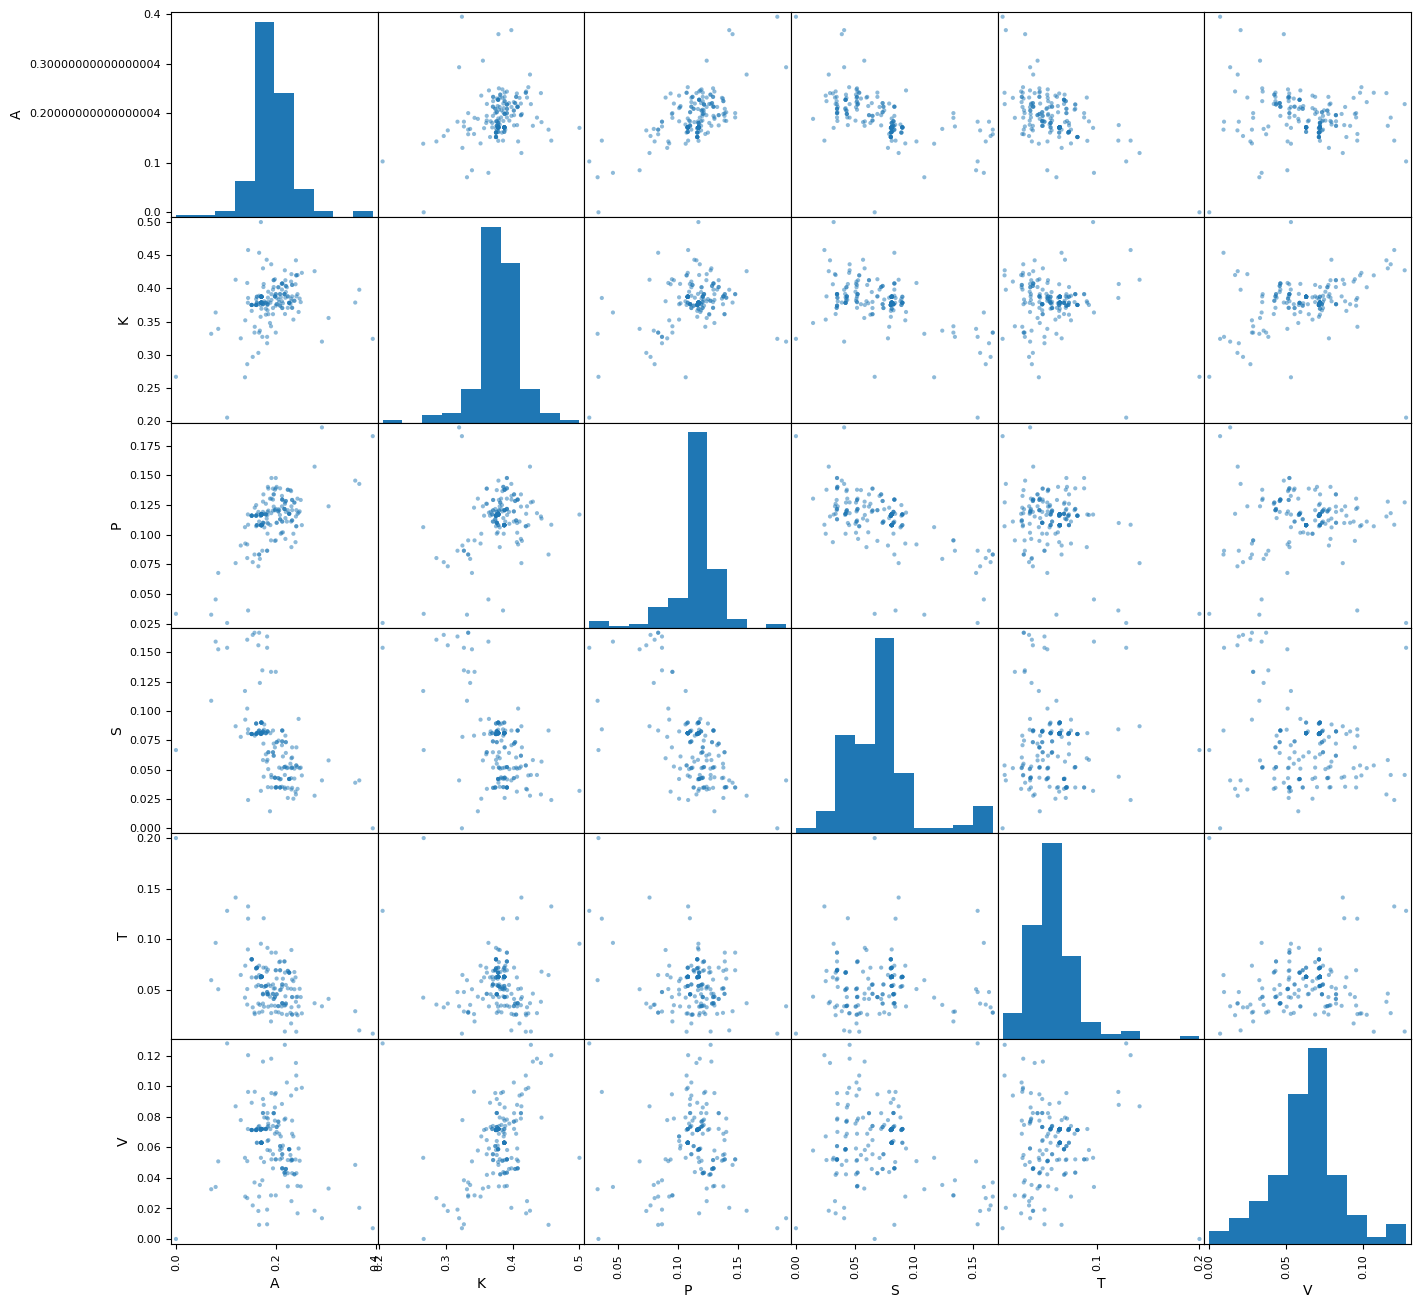

In [68]:
# Plotting a scatter matrix for most common residue types
_ = pd.plotting.scatter_matrix(freqs.loc[:, freqs.mean() > 1/20], figsize=(16, 16))

### Principal component analysis

In [69]:
# Performing PCA
# Standardising data
features = ortho[analyse_utils.amino_acids]
features = (features - features.mean()) / features.std()
features.fillna(0, inplace=True)

# Perform PCA
pca = PCA()

# Calculate principal components
pca_pcs = pd.DataFrame(pca.fit_transform(features), columns=[f'PC{i+1}' for i in range(len(features.columns))], index=features.index)

In [70]:
# Joining principal components to metadata
ortho = ortho[list(set(ortho.columns) - set(pca_pcs.columns))]
ortho = ortho.join(pca_pcs)

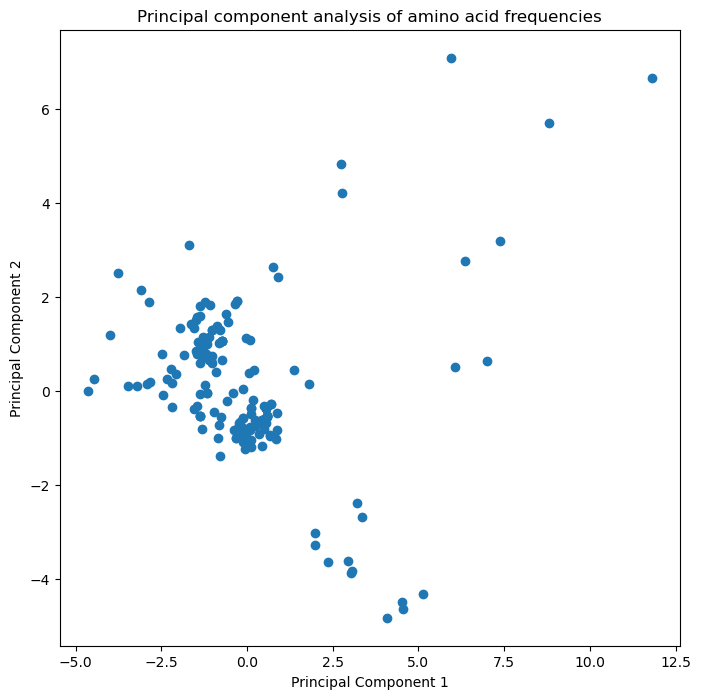

In [71]:
# Plot the first two principal components
plt.scatter(pca_pcs['PC1'], pca_pcs['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("Principal component analysis of amino acid frequencies")
plt.show()

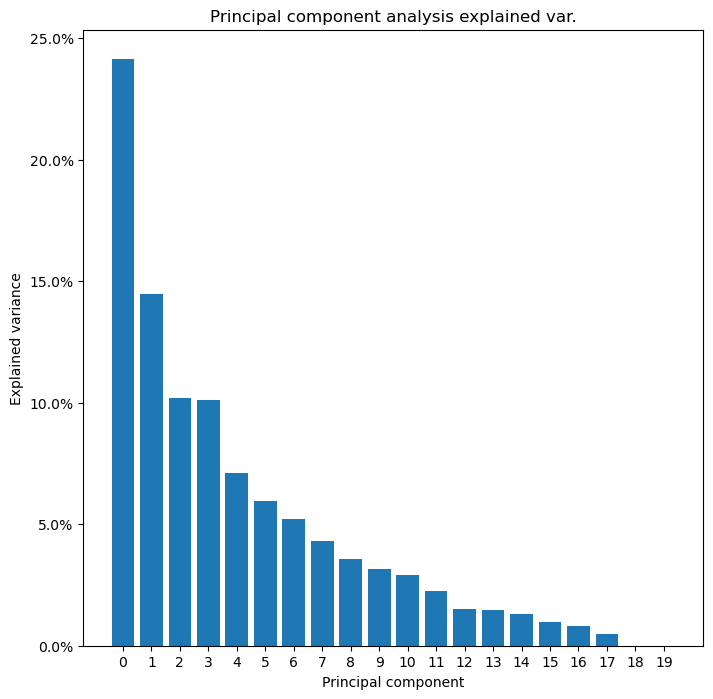

In [89]:
# Plot the explained variance
plt.bar(range(len(features.columns)), pca.explained_variance_ratio_)
plt.xticks(range(len(features.columns)))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.title('Principal component analysis explained var.')
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.show()

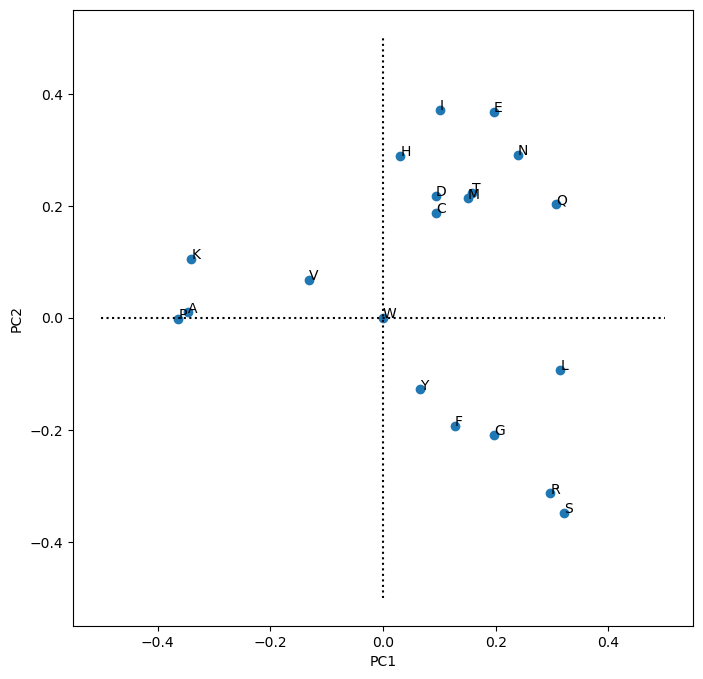

In [73]:
# Plotting rotational matrix for first two PCs
rotation_matrix = pca.components_.T
fig, ax = plt.subplots()
ax.scatter(rotation_matrix[:,0], rotation_matrix[:,1])
for i, feature_name in enumerate(features.columns):
    ax.annotate(feature_name, (rotation_matrix[i,0], rotation_matrix[i,1]))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.hlines(0,-0.5, 0.5, 'k', 'dotted')
ax.vlines(0,-0.5, 0.5, 'k', 'dotted')
plt.show()

### Clustering

#### Fitting

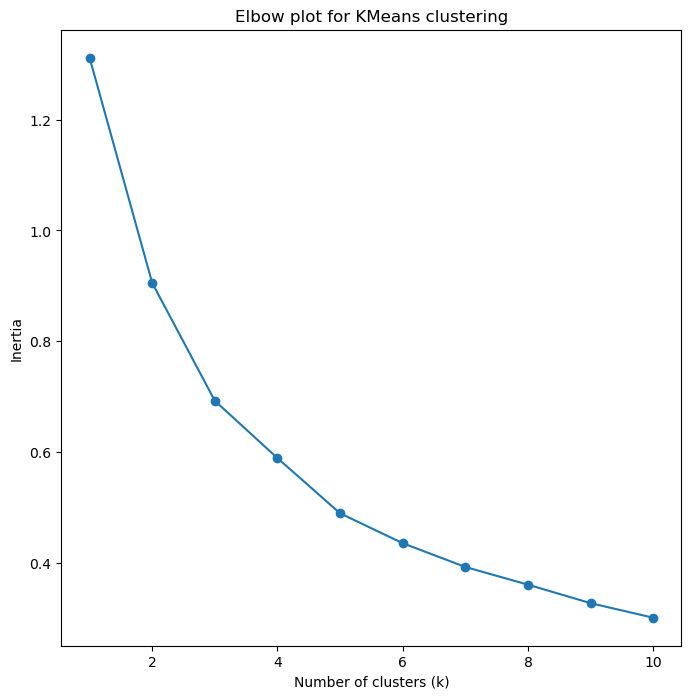

In [74]:
# Elbowplot for KMeans clustering
# Load the data
features = ortho[analyse_utils.amino_acids]

# Initialising an empty list to store the inertia values for different k values
inertia = []

# Defining a range of k values to test
k_values = range(1, 11)

# Performing KMeans clustering for each k value and storing the inertia value
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=50)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# Plotting the elbow plot
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow plot for KMeans clustering')
plt.show()

In [75]:
# Setting k-value
k = 2

Sequences in clusters
0    172
1     18
Name: cluster, dtype: int64


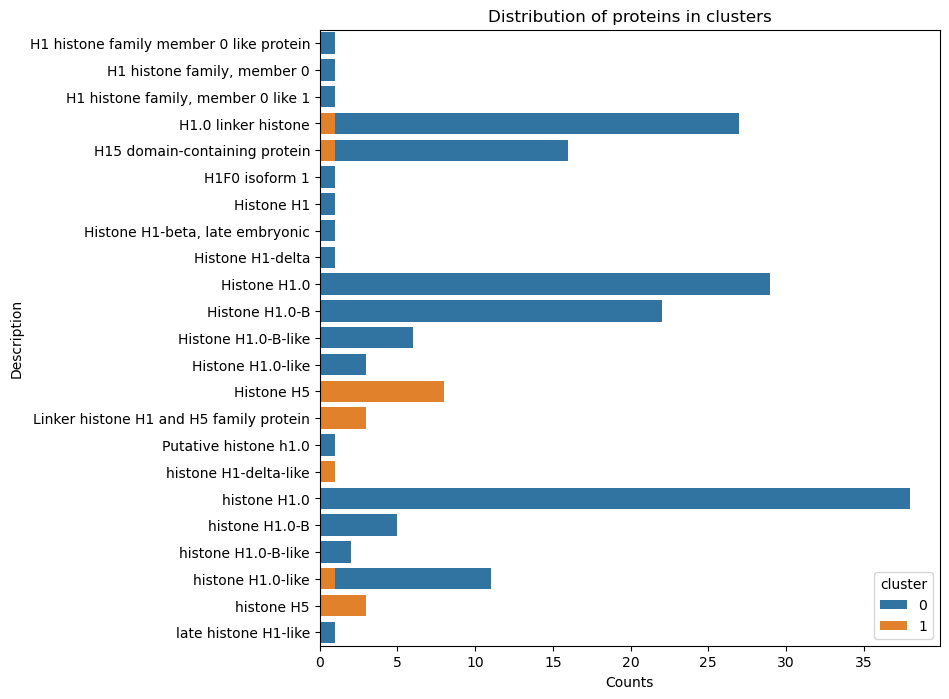

In [76]:
# Assigning labels from clustering
# Load the data
features = ortho[analyse_utils.amino_acids]

# Clustering
kmeans = KMeans(n_clusters=k, n_init=50)
kmeans.fit(features)

# Assigning labels
ortho['cluster'] = kmeans.predict(features)
print("Sequences in clusters")
print(ortho['cluster'].value_counts())

# Plotting protein assignment to clusters
sns.barplot(data=ortho.groupby(['description', 'cluster'])['variant'].count().reset_index(), x='variant', y='description', hue='cluster', dodge=False, orient='h')
plt.xlabel("Counts")
plt.ylabel("Description")
plt.title("Distribution of proteins in clusters")
plt.show()

#### Amino acid composition by cluster

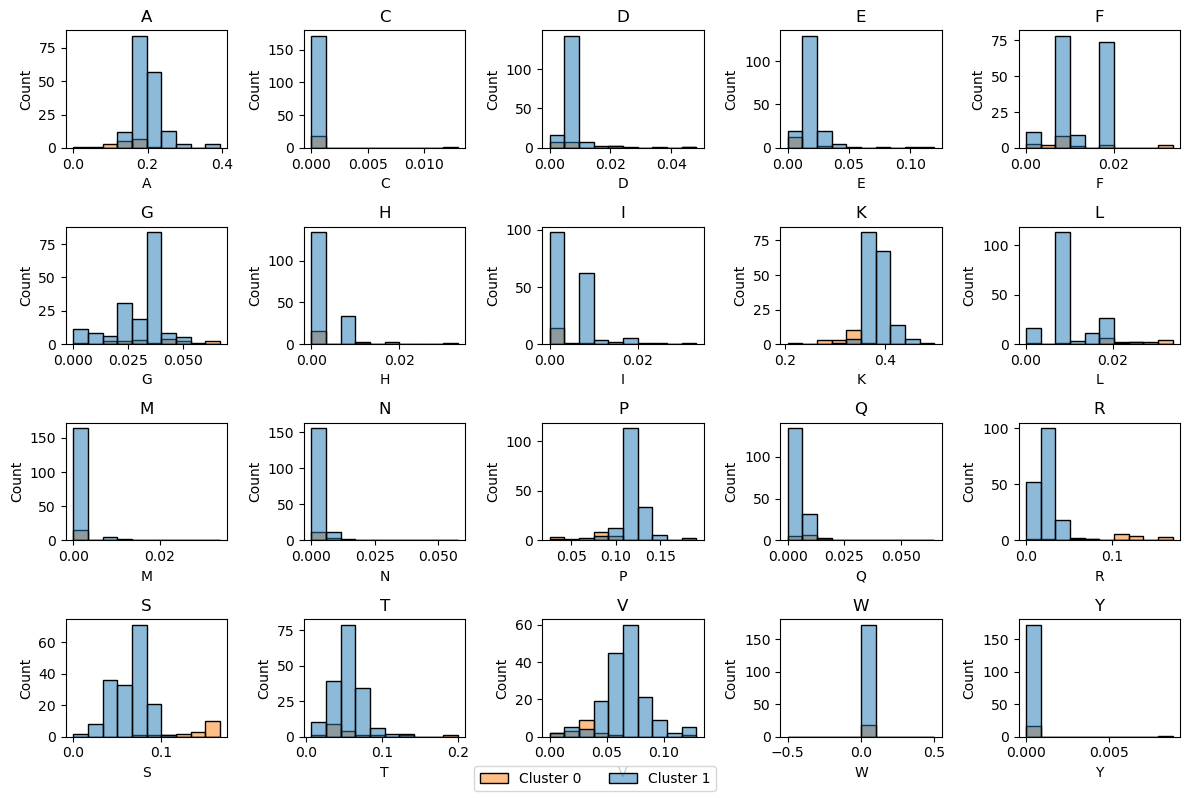

In [77]:
# Plotting amino acids distribution with clusterings
# Setting plot dimensions
dimensions = (4,5)
fig, axes = plt.subplots(*dimensions, figsize=(12,8))
amino_acids = np.reshape(analyse_utils.amino_acids, dimensions)

# Looping over subplots and amino acids
for i in range(dimensions[0]):
    for j in range(dimensions[1]):
        ax = axes[i,j]
        aa = amino_acids[i,j]
        sns.histplot(data=ortho, x=aa, hue='cluster', bins=10, ax=ax) #, multiple='stack')
        ax.set_title(aa)
        ax.get_legend().remove() # remove legend from individual subplots
    
# Add a common legend outside the subplots
fig.legend([f'Cluster {ki}' for ki in range(k)], ncols=k, loc='lower center')

plt.tight_layout()
plt.show()

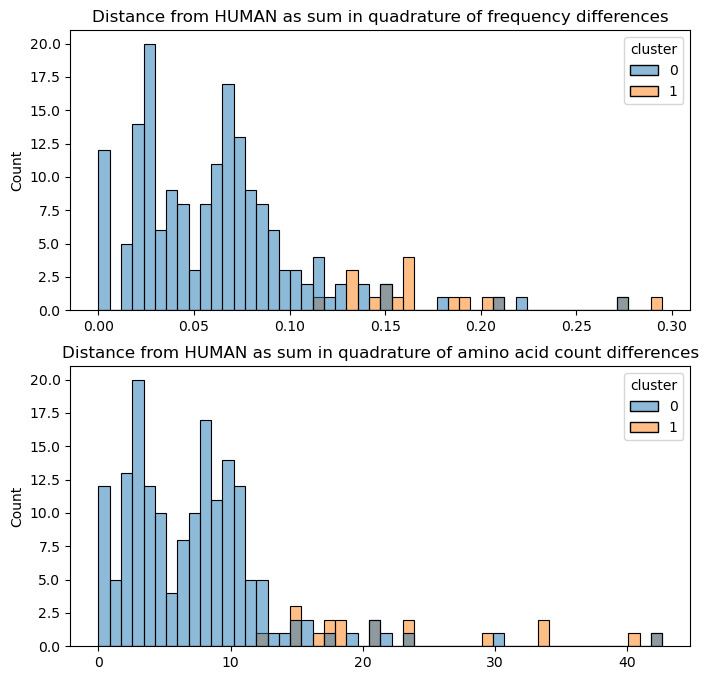

In [78]:
# Plotting sequence distance by cluster

# Method 1: Distance as sum in quadrature of frequency differences
plt.subplot(211)
sns.histplot(x=freq_diff, hue=ortho['cluster'], bins=50) #, multiple='stack')
plt.title("Distance from HUMAN as sum in quadrature of frequency differences")

# Method 2: Distance as sum in quadrature of amino acid count differences
plt.subplot(212)
sns.histplot(x=count_diff, hue=ortho['cluster'], bins=50) #, multiple='stack')
plt.title("Distance from HUMAN as sum in quadrature of amino acid count differences")

plt.rcParams["figure.figsize"] = (8,8)
plt.show()

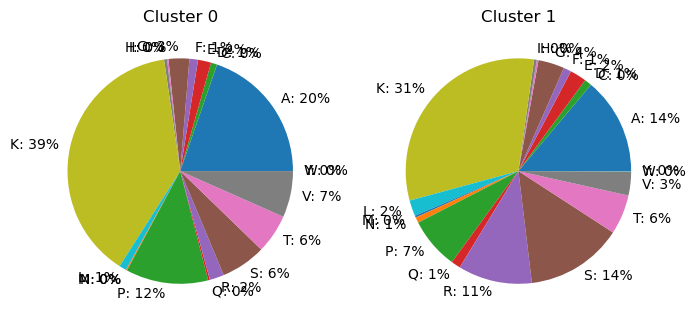

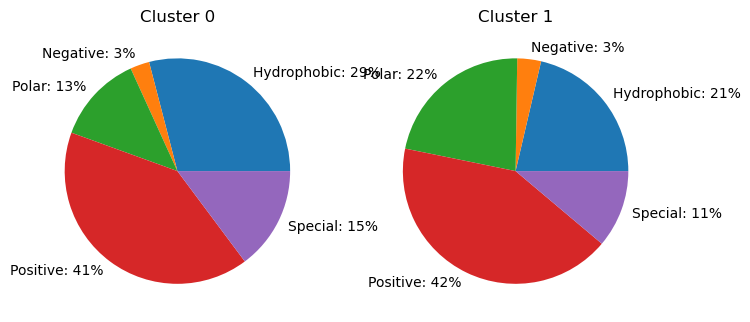

In [79]:
# Plotting relative amino acid contents in pie chart by cluster
ortho_pie = ortho.groupby('cluster')[analyse_utils.amino_acids].mean().transpose()

# Plotting by residue
fig, axes = plt.subplots(1, len(ortho_pie.columns))
for ax, cluster in zip(axes, ortho_pie.columns):
    ax.set_title(f'Cluster {cluster}')
    ax.pie(ortho_pie[cluster], labels=[f'{i}: {v:.0%}' for i, v in zip(ortho_pie.index, ortho_pie[cluster])])
plt.show()

# Plotting by type
ortho_pie['type'] = ortho_pie.index.map(analyse_utils.amino_acid_types)
ortho_pie = ortho_pie.groupby('type').sum()
fig, axes = plt.subplots(1, len(ortho_pie.columns))
for ax, cluster in zip(axes, ortho_pie.columns):
    ax.set_title(f'Cluster {cluster}')
    ax.pie(ortho_pie[cluster], labels=[f'{i}: {v:.0%}' for i, v in zip(ortho_pie.index, ortho_pie[cluster])])
plt.show()

#### CIDER parameters by cluster

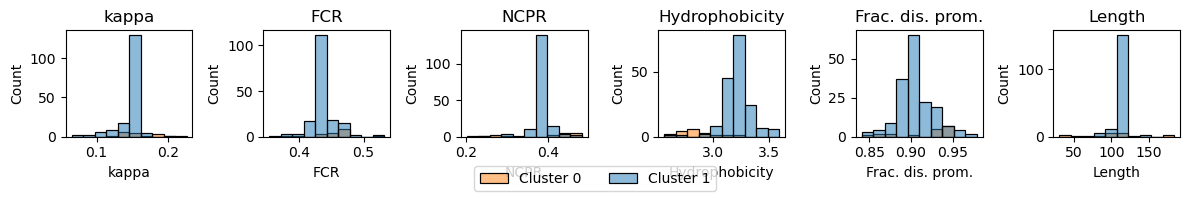

In [80]:
# Plotting CIDER parameters distribution with clusterings
# Joining parameters (previously calculated)
param_cols = params.columns

# Setting plot dimensions
fig, axes = plt.subplots(ncols=len(param_cols), figsize=(12,2))

# Looping over subplots and parameters
for ax, col in zip(axes, param_cols):
    sns.histplot(data=ortho, x=col, hue='cluster', bins=10, ax=ax)#, multiple='stack')
    ax.set_title(col)
    ax.get_legend().remove() # remove legend from individual subplots
    
# Add a common legend outside the subplots
fig.legend([f'Cluster {ki}' for ki in range(k)], ncols=k, loc='lower center')

plt.tight_layout()
plt.show()

#### PCA by cluster

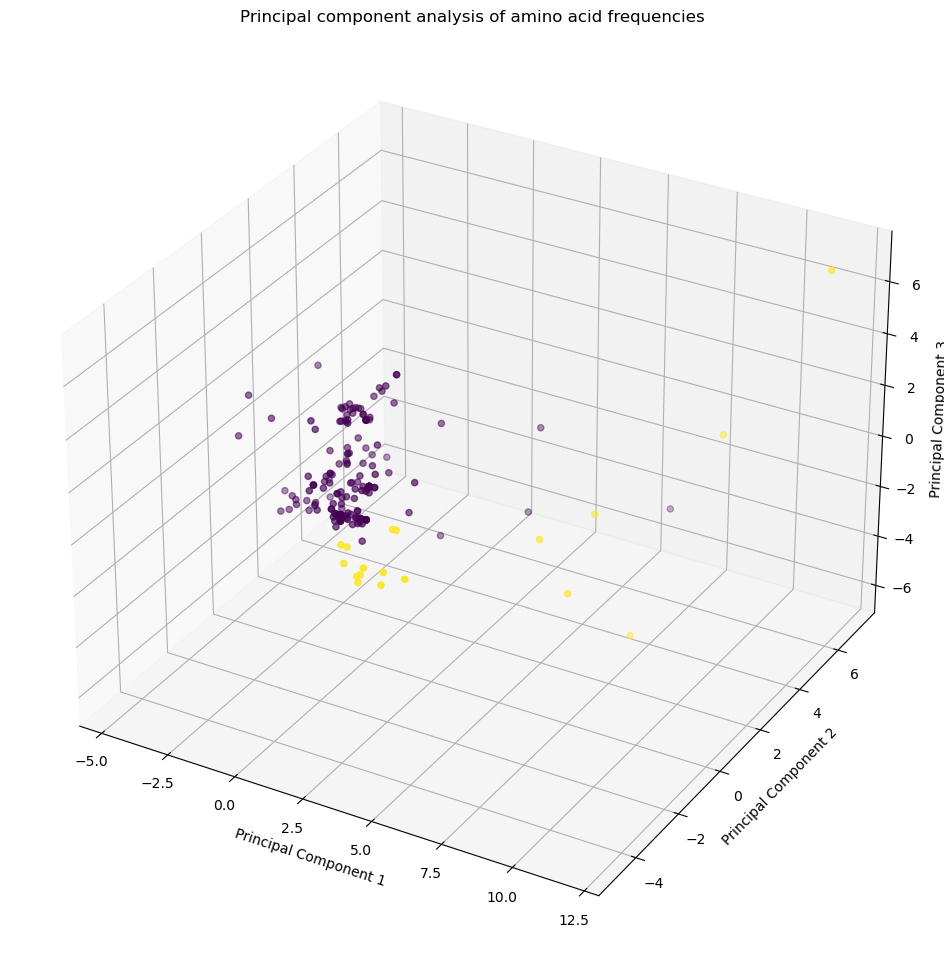

In [81]:
# Plotting PCA with clustering
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(ortho['PC1'], ortho['PC2'], ortho['PC3'], c=ortho['cluster'])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title("Principal component analysis of amino acid frequencies")
plt.show()

## $R_g$ evolution of H1.0

In [2]:
# Loading metadata
idpevo = analyse_utils.load_metadata('exp/idpevo_h1-0/idpevo_h1-0.json')

idpevo

location region                                           sequence  \
H1-0_AVG     None    CTD  KEAVASAPAKKSKSKSKKVAARKKFEVRATPSVKPGKKKKASKPVK...   

                                                   template   variant species  \
H1-0_AVG  [0_9TELE, 1_CYPVA, 2_FUNHE, 3_KRYMA, 4_NOTFU, ...  Averaged     NaN   

         description name uniprot_id  
H1-0_AVG         NaN  NaN        NaN

### Minimisation

In [3]:
# Loading minimisation evolution
minevo = pd.read_pickle('exp/idpevo_h1-0/results/min/evolution.pkl')

minevo

fasta       obs simulate  \
0    [K, E, A, V, A, S, A, P, A, K, K, S, K, S, K, ...  4.052589     True   
1    [K, E, A, V, A, S, A, P, A, K, K, S, K, S, K, ...  4.047305    False   
2    [K, E, A, V, A, S, A, P, A, K, K, K, K, S, K, ...  4.042089    False   
3    [K, E, A, V, A, S, A, P, A, K, K, K, K, S, K, ...   4.02696     True   
4    [K, E, A, V, A, S, A, P, A, K, K, K, K, S, K, ...   4.02696    False   
..                                                 ...       ...      ...   
977  [A, K, T, G, A, K, A, K, A, G, K, K, A, A, K, ...  3.722525    False   
978  [A, K, T, G, A, S, A, K, A, G, K, K, A, A, K, ...  3.718597    False   
979  [A, K, T, G, A, S, A, K, A, G, K, K, A, A, K, ...  3.728732    False   
980  [A, K, T, G, A, S, A, K, A, G, K, K, A, A, K, ...   3.73488    False   
981  [A, K, T, G, A, S, A, K, A, G, K, K, A, A, K, ...  3.831048    False   

        mc     mc_cp  
0     True  0.014427  
1     True  0.014427  
2     True  0.014427  
3     True  0.014427  
4     True  0.014427  
..     ...       ...  
977  False  0.013858  
978   True  0.013858  
979   True  0.013858  
980   True  0.013858  
981  False  0.013858  

[982 rows x 5 columns]

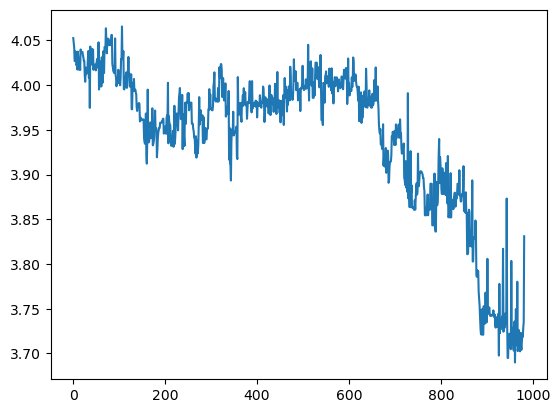

In [4]:
plt.plot(minevo.obs)

In [10]:
params = analyse_utils.cider_parameters(minevo.fasta.str.join(''))

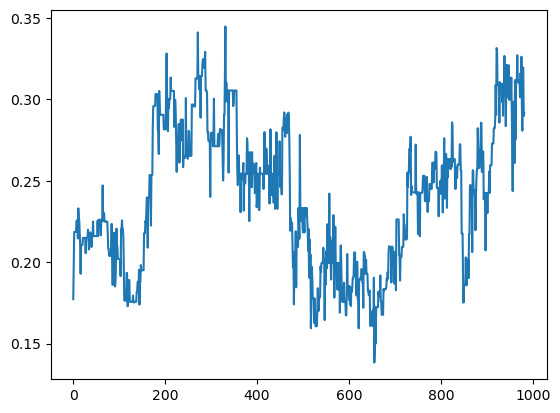

In [12]:
plt.plot(params.kappa)